# 1. 4개시군구 인구 데이터 전처리
---
## 📢 4개 시군구의 인구 특성을 추출
- compas에서 제공된 데이터 중 인구정보를 포함한 데이터
- 33.1인가구수 / 34.기초수급자현황 / 35.성연령별 총인구분포 / 36. 인구데이터(외국인)

In [1]:
### 33 ~ 36 의 데이터를 살펴 본 결과, 2020년 데이터가 대부분 누락되어 있어 통계청에서 유효한 데이터를 불러오도록 했다.

### 2020 행정구역별 인구, 가구, 주택 현황 데이터
### 출처 통계청 kosis(<a href="https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_1IN1502&conn_path=I2">링크</a>)

- 서울특별시
<p> '종로구', '중구', '용산구', '성동구', '광진구',
       '동대문구', '중랑구', '성북구', '강북구', '도봉구', '노원구', '은평구', '서대문구', '마포구',
       '양천구', '강서구', '구로구', '금천구', '영등포구', '동작구', '관악구', '서초구', '강남구',
       '송파구', '강동구'
</p>
- 수원시
<p>
    '장안구', '권선구', '팔달구', '영통구'
- 창원시
</p>  
<p>
    '의창구', '성산구',
       '마산합포구', '마산회원구', '진해구
</p>       
- 진주시 

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
from tqdm import tqdm 
import folium as f
import warnings 
warnings.filterwarnings('ignore')
tqdm.pandas()

/opt/app-root/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [3]:
import matplotlib.font_manager as fm
import matplotlib as mat
## 폰트 경로
font_path = './data/NanumBarunGothic.ttf' 
## FontProperties 인스턴스 생성
font_prop = fm.FontProperties(fname=font_path)
## 폰트 이름
font_name = font_prop.get_name()
plt.rcParams['font.family']= 'NanumBarunGothic'

## <1> 인구, 가구, 주택 현황

In [4]:
# pop_total = pd.read_csv('./data/인구_가구_및_주택_2020.csv', encoding='euc-kr', header=1)
# pop_total.head(3)
pop_total = pd.read_csv('./data/인구__가구_및_주택__읍면동.csv', encoding='euc-kr', header=1)
pop_total.head(3)

행정구역별(읍면동)  총인구 (명)   남자 (명)   여자 (명)  내국인-계 (명)  내국인-남자 (명)  내국인-여자 (명)  \
0      서울특별시  9586195  4647733  4938462    9219741     4474343     4745398   
1        종로구   151291    73062    78229     139718       67919       71799   
2         중구   128744    62147    66597     117252       56725       60527   

   외국인-계 (명)  외국인-남자 (명)  외국인-여자 (명)  ...  일반가구 (가구)  집단가구 (가구)  외국인가구 (가구)  \
0     366454      173390      193064  ...    3982290       2264      141970   
1      11573        5143        6430  ...      63414        115        4540   
2      11492        5422        6070  ...      55093         96        4628   

   주택-계 (호)  단독주택 (호)  아파트 (호)  연립주택 (호)  다세대주택 (호)  비거주용 건물내 주택 (호)  \
0   3015371    307075  1772670    110562     796066            28998   
1     46859     12259    15688      5460      12540              912   
2     42234      5967    26102      1944       7352              869   

   주택이외의 거처 (호)  
0        248125  
1          5663  
2          5695  

[3 rows x 21 columns]

In [5]:
pop_total.columns

Index(['행정구역별(읍면동)', '총인구 (명)', '남자 (명)', '여자 (명)', '내국인-계 (명)', '내국인-남자 (명)',
       '내국인-여자 (명)', '외국인-계 (명)', '외국인-남자 (명)', '외국인-여자 (명)', '가구-계 (가구)',
       '일반가구 (가구)', '집단가구 (가구)', '외국인가구 (가구)', '주택-계 (호)', '단독주택 (호)',
       '아파트 (호)', '연립주택 (호)', '다세대주택 (호)', '비거주용 건물내 주택 (호)', '주택이외의 거처 (호)'],
      dtype='object')

In [6]:
pop_total['행정구역별(읍면동)'].unique()

array(['서울특별시', '종로구', '중구', '용산구', '성동구', '광진구', '동대문구', '중랑구', '성북구',
       '강북구', '도봉구', '노원구', '은평구', '서대문구', '마포구', '양천구', '강서구', '구로구',
       '금천구', '영등포구', '동작구', '관악구', '서초구', '강남구', '송파구', '강동구', '경기도',
       '수원시', '장안구', '권선구', '팔달구', '영통구', '진주시', '창원시', '의창구', '성산구',
       '마산합포구', '마산회원구', '진해구'], dtype=object)

In [7]:
# 서울은 구 단위, 수원과 창원은 구 단위 및 시 단위, 진주는 시 단위의 인구 특성을 추출합니다
sgg_list = ['종로구', '중구', '용산구', '성동구', '광진구', '동대문구', '중랑구', '성북구', '강북구', '도봉구', '노원구', '은평구', '서대문구', '마포구', '양천구', '강서구', '구로구', '금천구', '영등포구', '동작구', '관악구', '서초구', '강남구', '송파구', '강동구',
        '장안구', '권선구', '팔달구', '영통구','의창구', '성산구', '마산합포구', '마산회원구', '진해구','진주시', '수원시', '창원시']
pop_total = pop_total[pop_total['행정구역별(읍면동)'].isin(sgg_list)]
pop_total.head(3)

행정구역별(읍면동)  총인구 (명)  남자 (명)  여자 (명)  내국인-계 (명)  내국인-남자 (명)  내국인-여자 (명)  \
1        종로구   151291   73062   78229     139718       67919       71799   
2         중구   128744   62147   66597     117252       56725       60527   
3        용산구   225882  109162  116720     208602       99866      108736   

   외국인-계 (명)  외국인-남자 (명)  외국인-여자 (명)  ...  일반가구 (가구)  집단가구 (가구)  외국인가구 (가구)  \
1      11573        5143        6430  ...      63414        115        4540   
2      11492        5422        6070  ...      55093         96        4628   
3      17280        9296        7984  ...      95714         89        5628   

   주택-계 (호)  단독주택 (호)  아파트 (호)  연립주택 (호)  다세대주택 (호)  비거주용 건물내 주택 (호)  \
1     46859     12259    15688      5460      12540              912   
2     42234      5967    26102      1944       7352              869   
3     74542     14064    37676      3969      18124              709   

   주택이외의 거처 (호)  
1          5663  
2          5695  
3          6611  

[3 rows x 21 columns]

## ** 다채로운 인구 특성 분석을 위해 특성을 추가합니다
1. 세대당 인구수 : 총인구 / 가구 수
2. 성비 : 남자 / 여자 * 100
3. 외국인 비율 : 외국인 수 / 총인구 * 100

In [8]:
pop_total['세대당 인구수'] = pop_total['총인구 (명)'] / pop_total['가구-계 (가구)']
pop_total['성비'] = pop_total['남자 (명)']/ pop_total['여자 (명)'] * 100
pop_total['외국인 비율'] = pop_total['외국인-계 (명)']/ pop_total['총인구 (명)'] * 100

## <2> 기초 수급자 현황

- 수원, 창원 데이터의 경우 '구' 단위가 아닌 '시'단위로 분류되어 있어, '구' 단위 데이터를 새로 불러옴
- 수원시 기초수급자 출처
kosis(https://kosis.kr/statHtml/statHtml.do?orgId=611&tblId=DT_K210002&conn_path=I2)
- 창원시 기초수급자 출처
https://www.changwon.go.kr/depart/bbs/view.do?bIdx=574279&ptIdx=255&mId=0501040200

In [9]:
# pop_total_data= pd.read_csv('./data/35.4개시도_성연령별_총인구분포.csv')
# foreign_data= pd.read_csv('./data/36.4개시도_인구데이터(외국인).csv')
poor_data= pd.read_csv('./data/34.4개시도_기초수급자현황.csv')
changwon_poor = pd.read_excel('./data/창원시기초생활보장수급자(2019년6월).xls')
suwon_poor = pd.read_csv('./data/수원시_국민기초생활보장_수급자_2019.csv', encoding='euc-kr', header=2)
single_data= pd.read_csv('./data/33.4개시도_1인가구수.csv')

In [10]:
poor_data.head()

date   sido sgg_nm  age  num
0  201706  서울특별시    종로구    4    4
1  201706  서울특별시    종로구   45   26
2  201706  서울특별시    종로구   46   55
3  201706  서울특별시    종로구   47   37
4  201706  서울특별시    종로구   48   51

In [11]:
poor_data['sgg_nm'].unique() 

array(['종로구', '중구', '용산구', '성동구', '광진구', '동대문구', '중랑구', '성북구', '강북구',
       '도봉구', '노원구', '은평구', '서대문구', '마포구', '양천구', '강서구', '구로구', '금천구',
       '영등포구', '동작구', '관악구', '서초구', '강남구', '송파구', '강동구', '수원시', '창원시',
       '진주시'], dtype=object)

In [12]:
poor_data['date'].unique() 

array([201706, 201707, 201708, 201709, 201710, 201711, 201712, 201801,
       201802, 201803, 201804, 201805, 201806, 201807, 201808, 201809,
       201810, 201811, 201812, 201901, 201902, 201903, 201904, 201905,
       201906, 201907, 201908, 201909, 201910, 201911, 201912, 202001,
       202002, 202003, 202004, 202005, 202006, 202007, 202008, 202009,
       202010, 202011, 202012, 202101, 202102, 202103, 202104, 202105])

In [13]:
# 창원, 수원시도 '구'단위 데이터가 필요하다.
# 그러나 20년도 창원,수원의 구단위 데이터는 구할수가 없어서 compas의 17 ~ 20 데이터와 결합하여 사용하기로 한다.

In [14]:
poor_data = poor_data[poor_data['date'].isin([201706, 201806, 201906, 202006])]

In [15]:
poor_num = poor_data.groupby(['sido','sgg_nm','date']).sum()[['num']].reset_index()
poor_suwon = poor_num.loc[3] # 2020 수원 total
poor_changwon = poor_num.loc[11] # 2020 창원 total
poor_2020 = pd.concat([poor_suwon, poor_changwon],axis=1).T

In [16]:
del poor_2020['sido'], poor_2020['date']
poor_2020.columns=['sgg_nm','num']

### 2.1. 수원

In [17]:
# suwon_poor['행정구역(구동)별(1)'].unique()
suwon_poor = suwon_poor[(suwon_poor['행정구역(구동)별(1)'].isin(['장안구', '권선구', '팔달구', '영통구'])) & (suwon_poor['행정구역(구동)별(2)']=='소계')]
suwon_poor = suwon_poor[['행정구역(구동)별(1)', '인원 (명)']]
suwon_poor.head(3)

행정구역(구동)별(1) 인원 (명)
3           장안구   5260
14          권선구    619
27          팔달구    127

새로 로드한 데이터는 19년 6월 기준이므로 20년 6월 추정치로 변경한다.
- 수원시 기초수급자 수 (2019.06) 20755 -> (2020.06)  22298
▶▶ <strong>1.07 배</strong> 증가

In [18]:
suwon_poor['인원 (명)'] = suwon_poor['인원 (명)'].astype(float) * 1.07 # 수원시 전체에서 1.07배 증가하였으므로 구별로 1.07배를 연산
suwon_poor['sido']= '경기도'
suwon_poor['행정구역(구동)별(1)']='수원시'+suwon_poor['행정구역(구동)별(1)']
suwon_poor = suwon_poor.rename(columns={'행정구역(구동)별(1)':'sgg_nm', '인원 (명)' :'num'})
suwon_poor.head(3)

sgg_nm      num sido
3   수원시장안구  5628.20  경기도
14  수원시권선구   662.33  경기도
27  수원시팔달구   135.89  경기도

### 2.2. 창원

In [19]:
changwon_poor = changwon_poor[changwon_poor['Unnamed: 1'].isin(['창원시마산합포구', '창원시마산회원구', '창원시성산구', '창원시의창구', '창원시진해구'])][['Unnamed: 1', 'Unnamed: 2']]
changwon_poor = changwon_poor.rename(columns={'Unnamed: 1' : 'sgg_nm' , 'Unnamed: 2' : 'num'})
changwon_poor.head(3)

sgg_nm   num
10  창원시마산합포구  5540
11  창원시마산회원구  5179
12    창원시성산구  1845

새로 로드한 데이터는 19년 6월 기준이므로 20년 6월 추정치로 변경한다.
- 창원시 기초수급자 수 (2019.06) 28081 -> (2020.06)  32357
▶▶ <strong>1.15 배</strong> 증가

In [20]:
changwon_poor['num'] = suwon_poor['num'].astype(float) * 1.15 # 창원시 전체에서 1.15배 증가하였으므로 구별로 1.15배를 연산

In [21]:
changwon_poor['sido'] = '경상남도'

### 2.3. 종합

- 기존 데이터(2020.06) + 수원/창원 추출 데이터

In [22]:
# 2.1 ~ 2.2 에서 만든 수원, 창원 구별 데이터와 기존 데이터를 종합
poor_num = poor_num[poor_num['date']==202006]
poor_num.drop('date', axis=1, inplace=True)
poor_df = pd.concat([poor_num, changwon_poor, suwon_poor])
poor_df.head(3)

sido sgg_nm      num
3    경기도    수원시  22298.0
7   경상남도    진주시  13686.0
11  경상남도    창원시  32357.0

In [23]:
poor_df['sgg_nm'] = poor_df['sgg_nm'].apply(lambda x : x.replace('창원시', '') if x!='창원시' else x)
poor_df['sgg_nm'] = poor_df['sgg_nm'].apply(lambda x : x.replace('수원시', '') if x!='수원시' else x)

In [24]:
poor_df['sgg_nm'].unique()

array(['수원시', '진주시', '창원시', '강남구', '강동구', '강북구', '강서구', '관악구', '광진구',
       '구로구', '금천구', '노원구', '도봉구', '동대문구', '동작구', '마포구', '서대문구', '서초구',
       '성동구', '성북구', '송파구', '양천구', '영등포구', '용산구', '은평구', '종로구', '중구',
       '중랑구', '마산합포구', '마산회원구', '성산구', '의창구', '진해구', '장안구', '권선구', '팔달구',
       '영통구'], dtype=object)

## <3> 1인가구 분포

1) <strong>서울특별시</strong>
'종로구', '중구', '용산구', '성동구', '광진구', '동대문구', '중랑구', '성북구', '강북구', '도봉구', '노원구', '은평구', '서대문구', '마포구', '양천구', '강서구', '구로구', '금천구', '영등포구', '동작구', '관악구', '서초구', '강남구', '송파구', '강동구'

2) <strong>수원시</strong>
'장안구', '권선구', '팔달구', '영통구'

3) <strong>창원시</strong>
'의창구', '성산구', '마산합포구', '마산회원구', '진해구

4) <strong>진주시</strong>

- 2020년 1인가구 분포 데이터 출처 kosis(https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_1PL1509&conn_path=I2)


In [25]:
single_data = pd.read_csv('./data/1인가구_시군구.csv', encoding='euc-kr')
single_data = single_data[(single_data['행정구역별(시군구)'].isin(sgg_list)) & (single_data['항목']=='1인가구')]
single_data.head()
# single_data['행정구역별(시군구)'].unique()

행정구역별(시군구) 성별      연령    항목  단위 2020 년  Unnamed: 6
1152        종로구  계      합계  1인가구 NaN  25983         NaN
1160        종로구  계  20세 미만  1인가구 NaN    398         NaN
1168        종로구  계   20~24  1인가구 NaN   3331         NaN
1176        종로구  계   25~29  1인가구 NaN   4111         NaN
1184        종로구  계   30~34  1인가구 NaN   2923         NaN

In [26]:
## 전체 데이터에서 1인가구 총합/20대 1인가구/65세 이상 1인가구만 추출합니다.
single_data = single_data[single_data['성별']=='계']
single_data = single_data[['행정구역별(시군구)', '연령','2020 년']]
single_data['연령'].unique()

array(['합계', '20세 미만', '20~24', '25~29', '30~34', '35~39', '40~44',
       '45~49', '50~54', '55~59', '60~64', '65~69', '70~74', '75~79',
       '80~84', '85세 이상'], dtype=object)

In [27]:
single_data['연령'] = single_data['연령'].apply(lambda x : '20대' if x in ['20~24', '25~29'] else x)
single_data['연령'] = single_data['연령'].apply(lambda x : '65세 이상' if x in ['65~69', '70~74', '75~79',
       '80~84', '85세 이상'] else x)
single_data = single_data[single_data['연령'].isin(['합계','20대','65세 이상'])]
single_data['2020 년'] = single_data['2020 년'].astype(int)
single_df = single_data.groupby(['행정구역별(시군구)', '연령']).sum().reset_index()
single_df.head()

행정구역별(시군구)      연령  2020 년
0        강남구     20대   14811
1        강남구  65세 이상   10335
2        강남구      합계   68999
3        강동구     20대    8961
4        강동구  65세 이상   10831

In [28]:
# single_df['행정구역별(시군구)'].unique() 시군구 unique 확인

In [29]:
# 추출하고자 하는 3가지의 특성값만 컬럼으로 만듭니다.
temp_data = single_df[['행정구역별(시군구)']]
temp_data.drop_duplicates(inplace=True)
for i in single_df['연령'].unique() :
    temp_data['single_'+i] = 0
temp_data.head(3)

행정구역별(시군구)  single_20대  single_65세 이상  single_합계
0        강남구           0              0          0
3        강동구           0              0          0
6        강북구           0              0          0

In [30]:
# 각 시군구별 컬럼에 해당하는 값을 매칭하여 삽입합니다.
for i in range(len(single_df)) :
    temp_name = single_df.loc[i, '연령']
    temp = temp_data[temp_data['행정구역별(시군구)']==single_df.loc[i, '행정구역별(시군구)']]
    temp[temp_name] = single_df.loc[i, '2020 년']
    temp_data.loc[temp.index, 'single_'+temp_name] = single_df.loc[i, '2020 년']
single_data = temp_data
single_data.head(3)

행정구역별(시군구)  single_20대  single_65세 이상  single_합계
0        강남구       14811          10335      68999
3        강동구        8961          10831      50316
6        강북구        7931          12704      45685

## <4> 최종 

### 1 ~ 3 과정에 거쳐 생성된 인구 특성 데이터프레임을 Merge합니다 

In [31]:
# Merge 기준 column을 만들어 주기 위해 rename을 해 줍니다.
pop_total = pop_total.rename(columns = {'행정구역별(읍면동)' : 'sgg_nm'})
# pop_total.head(1)

poor_df = poor_df.rename(columns = {'num' : 'poor_num'})
# poor_df.head(1)

single_data = single_data.rename(columns = {'행정구역별(시군구)' : 'sgg_nm' })
# single_data.head(1)

In [32]:
# 총 37개 시군구에 대한 인구 특성 데이터프레임을 생성합니다.
final_df = pd.merge(pop_total, poor_df)
final_df = pd.merge(final_df, single_data)
final_df.head(3)

sgg_nm  총인구 (명)  남자 (명)  여자 (명)  내국인-계 (명)  내국인-남자 (명)  내국인-여자 (명)  \
0    종로구   151291   73062   78229     139718       67919       71799   
1     중구   128744   62147   66597     117252       56725       60527   
2    용산구   225882  109162  116720     208602       99866      108736   

   외국인-계 (명)  외국인-남자 (명)  외국인-여자 (명)  ...  비거주용 건물내 주택 (호)  주택이외의 거처 (호)  \
0      11573        5143        6430  ...              912          5663   
1      11492        5422        6070  ...              869          5695   
2      17280        9296        7984  ...              709          6611   

    세대당 인구수         성비    외국인 비율   sido  poor_num  single_20대  single_65세 이상  \
0  2.222612  93.395033  7.649497  서울특별시    4461.0        7442           4897   
1  2.152298  93.318017  8.926241  서울특별시    4930.0       25946          31215   
2  2.226952  93.524674  7.650012  서울특별시    7282.0        8309           6395   

   single_합계  
0      25983  
1     127233  
2      36881  

[3 rows x 29 columns]

In [33]:
# len(final_df) 길이 확인

### ~ 추가 과정 ~
- 각 시,군,구의 총면적 대비 총 인구수(인구밀도)를 구합니다.
- 각 시,군,구의 경계 데이터는 국토교통부의 국가공간정보포털에서 가져옵니다. (<a href="http://data.nsdi.go.kr/dataset/15144">링크</a>)

In [34]:
## 각 시군구 경계 데이터에서 서울, 수원, 창원, 진주시 경계를 추출
seoul_area = gpd.GeoDataFrame.from_file('data/LARD_ADM_SECT_SGG_11.shp', encoding='cp949')
seoul_area = seoul_area.to_crs({'init':'epsg:4326'}) # 좌표계 epsg : 4326
kk_area = gpd.GeoDataFrame.from_file('data/LARD_ADM_SECT_SGG_41.shp', encoding='cp949')
kk_area = kk_area.to_crs({'init':'epsg:4326'}) # 좌표계 epsg : 4326
suwon_area = kk_area[kk_area['SGG_NM'].str.contains('수원')]
kn_area = gpd.GeoDataFrame.from_file('data/LARD_ADM_SECT_SGG_48.shp', encoding='cp949')
kn_area = kn_area.to_crs({'init':'epsg:4326'}) # 좌표계 epsg : 4326
changwon_jinju_area = kn_area[kn_area['ADM_SECT_C'].isin(['48170', '48127', '48121', '48129', '48125', '48123'])]
total_area = pd.concat([suwon_area, changwon_jinju_area, seoul_area]) # 4개 시군구 경계
# 시군구 실면적
# 실면적을 구하는 공식 : geometry 좌표계 epsg:6933으로 환산, 구해진 면적 / 10**6
total_area['total_area'] = total_area['geometry'].to_crs({'init': 'epsg:6933'})\
               .map(lambda p: p.area / 10**6 ) 

In [35]:
total_area['sgg_nm'] = total_area['SGG_NM'].apply(lambda x: x.replace('수원시', '').replace('서울시','').replace('창원시','')) 
total_area['sgg_nm'].unique()

array(['팔달구', '장안구', '영통구', '권선구', '진주시', '마산회원구', '의창구', '진해구', '마산합포구',
       '성산구', '강동구', '송파구', '강남구', '서초구', '관악구', '동작구', '영등포구', '금천구',
       '구로구', '강서구', '양천구', '마포구', '서대문구', '은평구', '노원구', '도봉구', '강북구',
       '성북구', '중랑구', '동대문구', '광진구', '성동구', '용산구', '중구', '종로구'],
      dtype=object)

In [36]:
df = pd.merge(total_area, final_df, how='outer') # 각 시,군,구의 총면적 데이터와 인구종합 데이터를 Merge
# df[df['total_area'].isnull()]
# 수원의 총 면적(4개 시군구 총합), 창원의 총 면적(5개시군구 종합) 값을 삽입
df.loc[35, 'total_area'] = total_area[total_area['sgg_nm'].isin(['팔달구', '장안구', '영통구', '권선구'])]['total_area'].sum() # 수원
df.loc[36, 'total_area'] = total_area[total_area['sgg_nm'].isin(['마산회원구', '의창구', '진해구', '마산합포구','성산구'])]['total_area'].sum() # 창원

In [37]:
# 인구밀도 값을 연산하여 넣습니다.
df['인구밀도(명/㎢)'] = df['총인구 (명)']  / df['total_area']  
df.head()

ADM_SECT_C  SGG_NM  SGG_OID COL_ADM_SE    GID  \
0      41115  수원시팔달구    340.0      41110  242.0   
1      41111  수원시장안구   1649.0      41110  243.0   
2      41117  수원시영통구   2610.0      41110  244.0   
3      41113  수원시권선구   1313.0      41110  245.0   
4      48170     진주시    369.0      48170   17.0   

                                            geometry  total_area sgg_nm  \
0  MULTIPOLYGON (((126.99527 37.27383, 126.99529 ...   13.097981    팔달구   
1  POLYGON ((126.96335 37.30029, 126.96338 37.300...   33.150856    장안구   
2  POLYGON ((127.03216 37.30956, 127.03229 37.309...   27.515846    영통구   
3  POLYGON ((126.92697 37.27208, 126.92731 37.272...   47.364953    권선구   
4  POLYGON ((128.30404 35.12710, 128.30363 35.126...  712.913143    진주시   

   총인구 (명)  남자 (명)  ...  주택이외의 거처 (호)   세대당 인구수          성비     외국인 비율  sido  \
0   187922   95112  ...          6144  2.213894  102.480336  10.832154   경기도   
1   278507  140771  ...          1292  2.574454  102.203491   3.575494   경기도   
2   370340  185687  ...         11902  2.537844  100.559969   2.604094   경기도   
3   373381  188046  ...          3997  2.502386  101.462757   4.116974   경기도   
4   352403  175605  ...          3385  2.374747   99.325219   1.823481  경상남도   

   poor_num  single_20대  single_65세 이상  single_합계     인구밀도(명/㎢)  
0    135.89        7137           5666      30497  14347.402184  
1   5628.20        6948           6736      30264   8401.200749  
2    665.54       14994           4485      44294  13459.153588  
3    662.33        7168           7123      41517   7883.064991  
4  13686.00       11923          13355      49332    494.314074  

[5 rows x 37 columns]

In [38]:
# final_df['sgg_nm'].unique() 

In [39]:
final_df.to_csv('./data/4개시군구_인구및주택현황.csv') # 최종 데이터프레임을 저장

# 2. 4개시군구 112 신고 데이터 전처리
---
## 4개 시군구의 112 신고 특성을 추출
- compas에서 제공된 데이터 중 신고 정보를 포함한 데이터
- 1.수원시 신고이력(격자)/ 3.3개시도 신고이력(관할경계) / 
- 39.경찰관서현황 데이터를 통해 시,군,구 단위 매칭

In [40]:
report_log = pd.read_csv('./data/3.3개시도_112신고이력(관할경계매핑).csv')
suwon_report_log = pd.read_csv('./data/1.수원시_112신고이력(격자_관할경계매핑).csv')

In [41]:
police_loc = pd.read_csv('./data/39.4개시도_경찰관서현황.csv')

## 수원시는 신고 데이터가 격자단위로 따로 있어서 4개시도 경찰관서에서 수원시 관서만 추출(분리) 해줍니다.
suwon_police_loc = police_loc[police_loc['psname'].str.contains('수원')]
suwon_police_loc['addr_2'] = suwon_police_loc['addr'].apply(lambda x: x.replace('수원시','').replace('경기도',''))
suwon_police_loc['sgg_nm'] = suwon_police_loc['addr_2'].apply(lambda x: x.strip().split(' ')[0])
suwon_police_loc['sgg_nm']= suwon_police_loc['sgg_nm'].apply(lambda x: x.replace('매탄2동','영통구'))

- 수원 관할서/파출소와 구 단위 매칭

In [42]:
suwon_df = pd.merge(suwon_report_log, suwon_police_loc[['name','sgg_nm']], how='left')
suwon_df[suwon_df['sgg_nm'].isnull()]['name'].unique()

array(['광교지구대', '창룡문지구대'], dtype=object)

In [43]:
# 구 단위가 매칭되지 않은 파출소 2곳에 데이터를 넣어줍니다.
suwon_df['sgg_nm'] = suwon_df.apply(lambda x: '영통구' if x['name']=='광교지구대' else x['sgg_nm'], axis=1)
suwon_df['sgg_nm'] = suwon_df.apply(lambda x: '장안구' if x['name']=='창룡문지구대' else x['sgg_nm'], axis=1)

In [44]:
# suwon_df['sgg_nm'].unique() 4개 구 확인

#### - 각 관서와 구 매칭하기
- 경찰청(<a herf="https://www.police.go.kr/user/bbs/BD_selectBbsList.do?q_bbsCode=1038&q_tab=1">링크</a>) 및 국가법령정보센터 제21조 2항 참조

In [45]:
# 각 관서와 구를 매칭합니다.
g_name =  {'서울강남경찰서' : '강남구' ,'서울수서경찰서' : '강남구', '서울강동경찰서' : '강동구',
  '서울강서경찰서' : '강서구', '서울강북경찰서' : '강북구', '서울광진경찰서' : '광진구',
  '서울관악경찰서' : '관악구', '서울구로경찰서' : '구로구', '서울금천경찰서' : '금천구',
  '서울노원경찰서' : '노원구', '서울도봉경찰서' : '도봉구', '서울동대문경찰서' : '동대문구',
  '서울동작경찰서' : '동작구', '서울마포경찰서' : '마포구', '서울서초경찰서' : '서초구',
  '서울방배경찰서' : '서초구', '서울서대문경찰서' : '서대문구', '서울성동경찰서' : '성동구',
  '서울성북경찰서' : '성북구', '서울종암경찰서' : '성북구', '서울송파경찰서' : '송파구',
  '서울양천경찰서' : '양천구', '서울영등포경찰서' : '영등포구' , '서울서부경찰서' : '은평구',
  '서울은평경찰서' : '은평구', '서울용산경찰서' : '용산구', '서울종로경찰서' : '종로구' ,
  '서울혜화경찰서' : '종로구' , '서울중부경찰서' : '중구', '서울남대문경찰서' : '중구',
  '서울중랑경찰서' : '중랑구' ,'진해경찰서' : '진해구','창원서부경찰서' : '의창구','창원중부경찰서' : '성산구',
    '마산중부경찰서' : '마산합포구','마산동부경찰서' : '마산회원구','진주경찰서' : '진주시'}

In [46]:
# 수원시 신고현황과 3개시군구 신고현황을 concat 하고 형식을 맞춰줍니다.(sgg_nm 컬럼에 시,군,구 정보 삽입)
log_total = pd.concat([suwon_df, report_log])
log_total['sgg_nm']=  log_total.apply(lambda x: g_name[x['psname']] if x['sgg_nm'] not in ['팔달구', '권선구', '영통구', '장안구'] else x['sgg_nm'], axis=1)
log_total['sgg_nm'].value_counts().head(5)

강남구     158186
송파구     114438
강서구     106612
영등포구    103655
서초구      97549
Name: sgg_nm, dtype: int64

In [47]:
# log_total['sgg_nm'].nunique() 시,군,구 총 35개

## <1> 112 신고현황 데이터

### 1.1 전체신고수

In [48]:
# 112 신고 현황 데이터에서 전체 누적 신고 수를 count 합니다.
total_report_cnt = log_total.groupby('sgg_nm').count().reset_index()[['sgg_nm','case_type']]
total_report_cnt.head(3)

sgg_nm  case_type
0    강남구     158186
1    강동구      80040
2    강북구      67416

### 1.2. case 별 신고수

In [49]:
# case_type 종류를 확인
log_total['case_type'].unique()

array(['비상벨', '기타_타기관', '폭력', '소음', '분실습득', '위험방지', '기타형사범', '상담문의',
       '교통사고', '교통불편', '시비', '주취자', '절도', '행패소란', '가정폭력', '서비스요청', '보호조치',
       '교통위반', '기타경범', '실종(실종아동 등)', '무전취식승차', '도박', '청소년비행'],
      dtype=object)

### case_type 분류
<li>*** case_type을 <strong>5가지 category</strong>로 분류 해봄 ***</li>
<li>1. 교통 관련 접수 : '교통불편', '교통사고','교통위반', '무전취식승차' </li>
<li>2. 시비, 폭력 관련 접수 : '시비', '가정폭력', '폭력', '행패소란'</li>
<li>3. 절도, 기타 경범죄 관련 접수 : '절도', '기타경범'. '도박', '기타형사범'</li>
<li>4. 서비스 관련 접수 : '서비스요청', '상담문의', '보호조치', '분실습득'</li>
<li>5. 기타 접수 : '비상벨', '위험방지', '소음', '기타_타기관', '주취자', '실종(실종아동 등)', '청소년비행' </li>

In [50]:
# 1. 교통관련 접수
traffic_list = ['교통불편', '교통사고','교통위반', '무전취식승차']
# 2. 시비 / 폭력
vio_list = [ '시비', '가정폭력', '폭력', '행패소란']
# 3. 절도 및 기타 경범죄
crime_list = [ '절도', '기타경범', '도박','기타형사범' ]
# 4. 서비스
serv_list = ['서비스요청', '상담문의', '보호조치', '분실습득']
# 5. 기타 등등
etc_list = ['비상벨', '위험방지', '소음', '기타_타기관', '주취자', '실종(실종아동 등)' , '청소년비행']

# 분류한 카테고리로 적용하여 case_cat 컬럼에 삽입.
log_total['case_cat'] = log_total['case_type'].apply(lambda x : '교통' if x in traffic_list else x)
log_total['case_cat'] = log_total['case_cat'].apply(lambda x : '시비/폭력' if x in vio_list else x)
log_total['case_cat'] = log_total['case_cat'].apply(lambda x : '절도/경범' if x in crime_list else x)
log_total['case_cat'] = log_total['case_cat'].apply(lambda x : '서비스' if x in serv_list else x)
log_total['case_cat'] = log_total['case_cat'].apply(lambda x : '기타' if x in etc_list else x)
log_total['case_cat'].value_counts()

서비스      597092
기타       552250
절도/경범    516370
시비/폭력    478707
교통       316994
Name: case_cat, dtype: int64

In [51]:
# 상단에서 분류한 5개 카테고리 별 누적 신고수를 count 합니다.
report_case_cnt = log_total.groupby(['sgg_nm','case_cat']).count().reset_index()[['sgg_nm','case_cat','case_type']]
report_case_cnt.head(3)

sgg_nm case_cat  case_type
0    강남구       교통      25233
1    강남구       기타      35152
2    강남구      서비스      34858

In [52]:
# 각 카테고리별 누적신고수를 base로 하는 column을 만듭니다.
temp_data = report_case_cnt[['sgg_nm']].drop_duplicates()
for i in report_case_cnt['case_cat'].unique() :
    temp_data[i+ '_case_cnt'] = 0
temp_data.head(3)

sgg_nm  교통_case_cnt  기타_case_cnt  서비스_case_cnt  시비/폭력_case_cnt  \
0     강남구            0            0             0               0   
5     강동구            0            0             0               0   
10    강북구            0            0             0               0   

    절도/경범_case_cnt  
0                0  
5                0  
10               0

In [53]:
# 각 컬럼에 맞는 갑을 삽입합니다.
for i in range(len(report_case_cnt)) :
    temp_name = report_case_cnt.loc[i, 'case_cat']
    temp = temp_data[temp_data['sgg_nm']==report_case_cnt['sgg_nm'].iloc[i]]
    temp[temp_name] = report_case_cnt['case_type'].iloc[i]
    temp_data.loc[temp.index , temp_name+'_case_cnt'] = report_case_cnt[report_case_cnt['case_cat']==temp_name].loc[i, 'case_type']
temp_data.head(3)

sgg_nm  교통_case_cnt  기타_case_cnt  서비스_case_cnt  시비/폭력_case_cnt  \
0     강남구        25233        35152         34858           25136   
5     강동구         8457        18231         18813           16093   
10    강북구         5843        13531         17810           15868   

    절도/경범_case_cnt  
0            37807  
5            18446  
10           14364

In [54]:
# 전체 누적 신고수와 카테고리별 신고수 dataframe을 merge합니다.
report_total = pd.merge(total_report_cnt, temp_data)
report_total.head()

sgg_nm  case_type  교통_case_cnt  기타_case_cnt  서비스_case_cnt  시비/폭력_case_cnt  \
0    강남구     158186        25233        35152         34858           25136   
1    강동구      80040         8457        18231         18813           16093   
2    강북구      67416         5843        13531         17810           15868   
3    강서구     106612        12024        24690         24219           21065   
4    관악구      97099        10113        19727         23578           19710   

   절도/경범_case_cnt  
0           37807  
1           18446  
2           14364  
3           24614  
4           23971

In [55]:
# report_total['sgg_nm'].unique() 시,군,구 확인용 출력

In [56]:
# 창원, 수원 구 데이터는 따로 담아줍니다(시 전체 데이터 만들기 위함)
changwon_ =report_total[report_total['sgg_nm'].isin(['진해구', '의창구', '마산합포구', '마산회원구','성산구'  ])]
suwon_ =report_total[report_total['sgg_nm'].isin(['팔달구', '영통구', '장안구', '권선구' ])]

In [57]:
# 창원시, 수원시 total
suwon_changwon_ = pd.concat([pd.DataFrame(changwon_.sum()).T ,  pd.DataFrame(suwon_.sum()).T ]).reset_index(drop=True)
suwon_changwon_.loc[0,'sgg_nm'] = '창원시'
suwon_changwon_.loc[1,'sgg_nm'] = '수원시'

In [58]:
# 창원시, 수원시 total과 시,군,구 total을 concat 합니다.
report_final = pd.concat([suwon_changwon_, report_total])
# report_final['sgg_nm'].nunique() 35 + 2개 확인

### *** % 단위 피쳐를 추가합니다
1. 교통신고비율 : 전체 신고 수 / 교통 신고 수 * 100
2. 기타및서비스비율 : 전체 신고 수 / 기타및서비스 신고 수  * 100
3. 절도폭력및경범비율 : 전체 신고 수 / 절도폭력 신고 수  * 100

In [59]:
report_final['교통신고비율'] =  report_final['교통_case_cnt'] / report_final['case_type'] * 100
report_final['기타및서비스비율'] =  (report_final['기타_case_cnt'] + report_final['서비스_case_cnt']) / report_final['case_type'] * 100
report_final['절도폭력및경범비율'] =  (report_final['절도/경범_case_cnt'] + report_final['시비/폭력_case_cnt']) / report_final['case_type'] * 100
report_final.head(3)

sgg_nm case_type 교통_case_cnt 기타_case_cnt 서비스_case_cnt 시비/폭력_case_cnt  \
0    창원시    171643       31566       47233        36195          35397   
1    수원시    223764       30480       56431        54253          43852   
0    강남구    158186       25233       35152        34858          25136   

  절도/경범_case_cnt   교통신고비율 기타및서비스비율 절도폭력및경범비율  
0          21252  18.3905  48.6055    33.004  
1          38748  13.6215  49.4646   36.9139  
0          37807  15.9515   44.258   39.7905

In [60]:
report_final.to_csv('./data/112신고현황.csv')

# 3. 4개시군구 관할서 데이터 전처리
---
## 4개 시군구의 관서 특성을 추출
- compas에서 제공된 데이터 중 관할서 정보를 포함한 데이터
- 11.4개시도 관할경계/39.경찰관서현황 데이터

In [61]:
police_con = pd.read_csv('./data/39.4개시도_경찰관서현황.csv')
police_border = gpd.read_file('./data/11.4개시도_경찰서_관할경계.geojson')

### 시,군,구 전체 영역 기준으로 파출소 영역 밖 면적 구하기
2020년 보도된 한 뉴스 기사에 따르면(<a href="https://www.pressian.com/pages/articles/2020100811011343168#0DKU">기사참조링크</a>) 지방청별 평균 출동시간은 
3~ 6분 내외인것으로 드러남. 따라서 6분 이내에 출동 할 수 있는 약 1km 반경을 파출소 영역으로 취급하고, 파출소 영역을 벗어난 area의
면적을 연산하여 구해본다.

In [62]:
# 위도, 경도만 있는 pandas dataframe 형식을 geopandas 형식으로 바꾸어주는 함수
def geo_transform(DataFrame) :
    # csv to geopandas
    # lon, lat data를 geometry로 변경
    DataFrame['lat'] = DataFrame['lat'].astype(float)
    DataFrame['lon'] = DataFrame['lon'].astype(float)
    DataFrame['geometry'] = DataFrame.apply(lambda row : Point([row['lon'], row['lat']]), axis=1)
    DataFrame = gpd.GeoDataFrame(DataFrame, geometry='geometry')
    DataFrame.crs = {'init':'epsg:4326'}
    DataFrame = DataFrame.to_crs({'init':'epsg:4326'}) # 좌표계 epsg : 4326
    return DataFrame

In [63]:
# 각 시, 군, 구 경계 데이터를 로드합니다.
seoul_area = gpd.GeoDataFrame.from_file('data/LARD_ADM_SECT_SGG_11.shp', encoding='cp949')
seoul_area = seoul_area.to_crs({'init':'epsg:4326'}) # 좌표계 epsg : 4326
kk_area = gpd.GeoDataFrame.from_file('data/LARD_ADM_SECT_SGG_41.shp', encoding='cp949')
kk_area = kk_area.to_crs({'init':'epsg:4326'}) # 좌표계 epsg : 4326
suwon_area = kk_area[kk_area['SGG_NM'].str.contains('수원')]
kn_area = gpd.GeoDataFrame.from_file('data/LARD_ADM_SECT_SGG_48.shp', encoding='cp949')
kn_area = kn_area.to_crs({'init':'epsg:4326'}) # 좌표계 epsg : 4326
changwon_jinju_area = kn_area[kn_area['ADM_SECT_C'].isin(['48170', '48127', '48121', '48129', '48125', '48123'])]
total_area = pd.concat([suwon_area, changwon_jinju_area, seoul_area])
# 시군구 실면적
total_area['total_area'] = total_area['geometry'].to_crs({'init': 'epsg:6933'})\
               .map(lambda p: p.area / 10**6 ) 

In [64]:
# 위도, 경도 데이터를 geometry로 환산합니다.
police_con = geo_transform(police_con)
# 1km 반경의 buffer 생성
buf_poly = gpd.GeoDataFrame({'geometry': police_con.buffer(0.01)}, crs='epsg:4326')
origin_ = total_area.groupby(['SGG_NM']).apply(lambda x : x.area.sum())
print(origin_)  # 전체 영역
dif_area = gpd.overlay(total_area, buf_poly, how='difference')
dif_area = dif_area.dissolve(by='SGG_NM')
print(dif_area) # buffer로 생성된 영역
dif_area.reset_index(inplace=True)


# ax = dif_area.plot(column='NAME', figsize=(8,8), alpha=0.8)
# ax.set_title("total - Police Buffer", fontsize=20)
# ax.set_axis_off()
# plt.show()

dif_area = dif_area.dissolve(by='SGG_NM') # 전체 영역(시군구 기준)에서 buffer 영역 제외
print("전체 대비 미커버지역 비율")
print(round(dif_area.area / origin_ * 100))
temp = round(dif_area.area / origin_ * 100)

SGG_NM
강남구         0.004024
강동구         0.002504
강북구         0.002413
강서구         0.004223
관악구         0.003011
광진구         0.001739
구로구         0.002050
금천구         0.001325
동대문구        0.001453
동작구         0.001670
마포구         0.002434
서대문구        0.001804
서울시노원구      0.003634
서울시도봉구      0.002112
서울시성북구      0.002512
서초구         0.004776
성동구         0.001713
송파구         0.003450
수원시권선구      0.004811
수원시영통구      0.002795
수원시장안구      0.003370
수원시팔달구      0.001331
양천구         0.001780
영등포구        0.002501
용산구         0.002232
은평구         0.003040
종로구         0.002448
중구          0.001017
중랑구         0.001893
진주시         0.070568
창원시마산합포구    0.023838
창원시마산회원구    0.008999
창원시성산구      0.008189
창원시의창구      0.020922
창원시진해구      0.012010
dtype: float64
                                                   geometry ADM_SECT_C  \
SGG_NM                                                                   
강남구       MULTIPOLYGON (((127.01495 37.52457, 127.01468 ...      11680   
강동구       MULTIPOLYGO

### 추가로 관서 기준으로도 면적을 구해봅니다.

In [65]:
# 과정은 위와 동일
buf_poly = gpd.GeoDataFrame({'geometry': police_con.buffer(0.01)}, crs='epsg:4326')
origin_ = police_border.groupby(['NAME']).apply(lambda x : x.area.sum())
print(origin_)
police_dif_area = gpd.overlay(police_border, buf_poly, how='difference')
police_dif_area = police_dif_area.dissolve(by='NAME')
print(police_dif_area) 
police_dif_area.reset_index(inplace=True)


# ax = police_dif_area.plot(column='NAME', figsize=(8,8), alpha=0.8)
# ax.set_title("total - Police Buffer", fontsize=20)
# ax.set_axis_off()
# plt.show()

police_dif_area = police_dif_area.dissolve(by='NAME') 
print("전체 대비 미커버지역 비율")
print(round(police_dif_area.area / origin_ * 100))

NAME
마산동부경찰서     0.009122
마산중부경찰서     0.023160
서울강남경찰서     0.001238
서울강동경찰서     0.002387
서울강북경찰서     0.002415
서울강서경찰서     0.003899
서울관악경찰서     0.003006
서울광진경찰서     0.002229
서울구로경찰서     0.002047
서울금천경찰서     0.001317
서울남대문경찰서    0.000318
서울노원경찰서     0.003643
서울도봉경찰서     0.002112
서울동대문경찰서    0.001465
서울동작경찰서     0.001653
서울마포경찰서     0.002921
서울방배경찰서     0.000940
서울서대문경찰서    0.001781
서울서부경찰서     0.000978
서울서초경찰서     0.003703
서울성동경찰서     0.001801
서울성북경찰서     0.001696
서울송파경찰서     0.003133
서울수서경찰서     0.002563
서울양천경찰서     0.001775
서울영등포경찰서    0.001988
서울용산경찰서     0.002559
서울은평경찰서     0.002064
서울종로경찰서     0.001920
서울종암경찰서     0.000805
서울중랑경찰서     0.001879
서울중부경찰서     0.000694
서울혜화경찰서     0.000531
수원남부경찰서     0.004188
수원서부경찰서     0.003896
수원중부경찰서     0.004156
진주경찰서       0.070530
진해경찰서       0.012006
창원서부경찰서     0.019456
창원중부경찰서     0.009484
dtype: float64
                                                   geometry  PNAME
NAME                                                              
마산동부경찰

### 구별 관할서와 파출소(치안안전센터) 개수를 구합니다

In [66]:
police_df = gpd.overlay(police_con, total_area, how='intersection')[['psname','name','SGG_NM','total_area']]
police_df.head(3)

psname   name SGG_NM  total_area
0  진주경찰서  개양파출소    진주시  712.913143
1  진주경찰서  금산파출소    진주시  712.913143
2  진주경찰서  남강지구대    진주시  712.913143

In [67]:
# psname_cnt : 관할서 개수
psname_cnt = police_df.drop_duplicates(subset='psname').groupby('SGG_NM').count().reset_index()[['SGG_NM','name']].rename(columns={'name' : 'police_cnt'})
# name_cnt : 파출소(치안안전센터) 개수 
name_cnt = police_df.groupby('SGG_NM').count().reset_index()[['SGG_NM','name']].rename(columns={'name' : 'security_cnt'})
# psname_cnt / name_cnt를 Merge
police_con_df = pd.merge(psname_cnt, name_cnt, on='SGG_NM',how='outer')

In [68]:
# 앞서 구했던 buffer 제외 면적 비율과 최종 Merge
police_con_df_ =  pd.merge(police_con_df, pd.DataFrame(temp).reset_index().rename(columns={ 0 : 'remain_area_ratio'}) , how='outer')
police_con_df_.head(3)

SGG_NM  police_cnt  security_cnt  remain_area_ratio
0    강남구         2.0            16               25.0
1    강동구         1.0            10               31.0
2    강북구         1.0             9               55.0

In [69]:
police_con_df_.isnull().sum() # police_cnt null 확인

SGG_NM               0
police_cnt           2
security_cnt         0
remain_area_ratio    0
dtype: int64

In [70]:
# 관할서가 없는 구에는 0으로 채웁니다.
police_con_df['police_cnt'].fillna(0, inplace=True)

In [71]:
## 수원시, 창원시 전체에 대한 row 값을 따로 생성해줍니다.
suwon_ =  gpd.GeoDataFrame([['수원시', suwon_area.unary_union]], columns=['SGG_NM','geometry'], crs={'init' : 'epsg:4326'})
changwon_ =  gpd.GeoDataFrame([['창원시', changwon_jinju_area[1:].unary_union]], columns=['SGG_NM','geometry'], crs={'init' : 'epsg:4326'})

In [72]:
## 수원시, 창원시 전체에 대한 buffer를 만들고 영역값을 계산합니다.

## 수원시
buf_poly = gpd.GeoDataFrame({'geometry': police_con.buffer(0.01)}, crs='epsg:4326')
origin_ = suwon_.groupby(['SGG_NM']).apply(lambda x : x.area.sum())
dif_area = gpd.overlay(suwon_, buf_poly, how='difference')
dif_area = dif_area.dissolve(by='SGG_NM')
dif_area.reset_index(inplace=True)
dif_area = dif_area.dissolve(by='SGG_NM')
suwon_['remain_area_ratio'] = round(dif_area.area / origin_ * 100).values[0]
suwon_['total_area'] =  suwon_['geometry'].to_crs({'init': 'epsg:6933'})\
               .map(lambda p: p.area / 10**6 )


## 창원시
buf_poly = gpd.GeoDataFrame({'geometry': police_con.buffer(0.01)}, crs='epsg:4326')
origin_ = changwon_.groupby(['SGG_NM']).apply(lambda x : x.area.sum())
dif_area = gpd.overlay(changwon_, buf_poly, how='difference')
dif_area = dif_area.dissolve(by='SGG_NM')
dif_area.reset_index(inplace=True)
dif_area = dif_area.dissolve(by='SGG_NM')
changwon_['remain_area_ratio'] = round(dif_area.area / origin_ * 100).values[0]
changwon_['total_area'] =  changwon_['geometry'].to_crs({'init': 'epsg:6933'})\
               .map(lambda p: p.area / 10**6 )

## 수원 + 창원 
suwon_changwon_ = pd.concat([suwon_, changwon_])[['SGG_NM','remain_area_ratio','total_area']]
suwon_changwon_.head(3)

SGG_NM  remain_area_ratio  total_area
0    수원시               50.0  121.123623
0    창원시               88.0  747.033877

In [73]:
# 창원,수원시 데이터와 전체 데이터를 Merge합니다.
pol_total = pd.merge(police_con_df_, suwon_changwon_.drop(['total_area'], axis=1), how='outer')

In [74]:
# 수원시, 창원시 데이터에 빈 값을 채워 넣습니다(각 구의 총합으로)
pol_total.loc[35, 'police_cnt']= police_con_df[police_con_df['SGG_NM'].str.contains('수원')]['police_cnt'].sum() # 수원
pol_total.loc[36, 'police_cnt']= police_con_df[police_con_df['SGG_NM'].str.contains('창원')]['security_cnt'].sum()# 창원

pol_total.loc[35, 'security_cnt']= police_con_df[police_con_df['SGG_NM'].str.contains('수원')]['security_cnt'].sum() # 수원
pol_total.loc[36, 'security_cnt'] = police_con_df[police_con_df['SGG_NM'].str.contains('창원')]['security_cnt'].sum()# 창원

pol_total.head() # 결과 확인

SGG_NM  police_cnt  security_cnt  remain_area_ratio
0    강남구         2.0          16.0               25.0
1    강동구         1.0          10.0               31.0
2    강북구         1.0           9.0               55.0
3    강서구         1.0          11.0               52.0
4    관악구         1.0          10.0               43.0

In [75]:
pol_total.to_csv('./data/관할서영역및개수.csv')

# 4. 4개시군구 시설물 데이터 전처리
---
## 4개 시군구의 시설물 특성을 추출
- compas에서 제공된 데이터 중 시설물 정보를 포함한 데이터
- 22.보안등현황 / 23.비상벨현황 / 24.cctv설치현황 / 27.공원현황
- 42.편의점현황 / 40.어린이놀이시설현황 / 8. 유흥업소현황
- 시,군,구 경계 데이터를 통해 시,군,구 단위 매칭

In [76]:
def geo_transform(DataFrame) :
    # csv to geopandas
    # lon, lat data를 geometry로 변경
    DataFrame['lat'] = DataFrame['lat'].astype(float)
    DataFrame['lon'] = DataFrame['lon'].astype(float)
    DataFrame['geometry'] = DataFrame.apply(lambda row : Point([row['lon'], row['lat']]), axis=1)
    DataFrame = gpd.GeoDataFrame(DataFrame, geometry='geometry')
    DataFrame.crs = {'init':'epsg:4326'}
    DataFrame = DataFrame.to_crs({'init':'epsg:4326'}) # 좌표계 epsg : 4326
    return DataFrame

In [77]:
slight_con = pd.read_csv('./data/22.4개시도_보안등현황.csv')
slight_con = geo_transform(slight_con)
bell_con = gpd.read_file('./data/23.4개시도_안전비상벨현황.geojson')
#bell_con = geo_transform(bell_con)
cctv_con = pd.read_csv('./data/24.4개시도_CCTV설치현황.csv')
cctv_con = geo_transform(cctv_con)

In [78]:
police_border = gpd.read_file('./data/11.4개시도_경찰서_관할경계.geojson')
police_border.head()

NAME PNAME                                           geometry
0    진주경찰서   경남청  MULTIPOLYGON (((128.26697 35.12927, 128.26697 ...
1  창원서부경찰서   경남청  MULTIPOLYGON (((128.63363 35.22152, 128.63357 ...
2  창원중부경찰서   경남청  MULTIPOLYGON (((128.60966 35.15093, 128.60956 ...
3  마산동부경찰서   경남청  MULTIPOLYGON (((128.62696 35.21714, 128.62695 ...
4  마산중부경찰서   경남청  MULTIPOLYGON (((128.43007 35.05918, 128.43005 ...

- 행정구역경계데이터 출처 : 국가공간정보포털 오픈마켓(<a href="http://data.nsdi.go.kr/dataset/15144">링크</a>) 

In [79]:
# 서울
seoul_area = gpd.GeoDataFrame.from_file('data/LARD_ADM_SECT_SGG_11.shp', encoding='cp949')
# 경기 --> 수원시 추출
kk_area = gpd.GeoDataFrame.from_file('data/LARD_ADM_SECT_SGG_41.shp', encoding='cp949')
suwon_area = kk_area[kk_area['SGG_NM'].str.contains('수원')]
# 경남 --> 창원통합시(48120), 진주시 추출(48170)
kn_area = gpd.GeoDataFrame.from_file('data/LARD_ADM_SECT_SGG_48.shp', encoding='cp949')
kn_area['ADM_SECT_C'] = kn_area['ADM_SECT_C'].astype(str)
changwon_jinju_area = kn_area[kn_area['COL_ADM_SE'].isin(['48120', '48170'])]
changwon_jinju_area.drop(21, inplace=True) # index 21. 창원전체
# 편의를 위해 서울, 창원, 진주 지역 데이터프레임 합침
total_area = pd.concat([seoul_area, changwon_jinju_area, suwon_area])
total_area = total_area.to_crs({'init' : 'epsg:4326'})
total_area['SGG_NM'] = total_area['SGG_NM'].apply(lambda x: x.replace('서울시', ''))

## <1> 보안등 

In [80]:
len(slight_con)

218995

In [81]:
slight_con['address'].isnull().sum()

10979

In [82]:
# geometry 매칭을 위해 주소에서 시,군,구 추출
slight_con['sgg_nm'] = slight_con['address'].apply(lambda x: str(x).split(' ')[1] if ' ' in str(x) else x)
slight_con['sgg_nm'].unique()

array(['진주시', '창원시', '강남구', ..., '285-9', '285-8', '산20'], dtype=object)

In [83]:
sgg_idx_list = slight_con[(slight_con['sgg_nm'].str.contains('시'))| (slight_con['sgg_nm'].str.contains('구'))].index
no_addr_df = slight_con.drop(sgg_idx_list) 
no_addr_df.head(3) # 주소 값이 null인 row들 

year address  securitylight_cnt         lon        lat  \
44736   NaN     NaN                  1  126.837775  37.574003   
44746   NaN     NaN                  1  126.850622  37.565477   
44747   NaN     NaN                  1  126.850622  37.565477   

                         geometry sgg_nm  
44736  POINT (126.83778 37.57400)    NaN  
44746  POINT (126.85062 37.56548)    NaN  
44747  POINT (126.85062 37.56548)    NaN

In [84]:
## address 값이 시, 군, 구 형식이 아닌 row들에 시군구 값을 매칭 해줌## 
no_addr_map = gpd.overlay(no_addr_df, total_area, how='intersection')
no_addr_map['sgg_nm']=no_addr_map['SGG_NM']
no_addr_map.head(3)

year address  securitylight_cnt         lon        lat sgg_nm ADM_SECT_C  \
0   NaN    None                  1  126.837775  37.574003    강서구      11500   
1   NaN    None                  1  126.850622  37.565477    강서구      11500   
2   NaN    None                  1  126.850622  37.565477    강서구      11500   

  SGG_NM  SGG_OID COL_ADM_SE  GID                    geometry  
0    강서구       65      11500  136  POINT (126.83778 37.57400)  
1    강서구       65      11500  136  POINT (126.85062 37.56548)  
2    강서구       65      11500  136  POINT (126.85062 37.56548)

In [85]:
# 수원, 창원 시군구 재매칭(일부 형식이 안 맞아서..)
suwon_changwon_ = slight_con[(slight_con['sgg_nm'].str.contains('창원'))| (slight_con['sgg_nm'].str.contains('수원'))]
suwon_changwon_['SGG_NM'] = suwon_changwon_['address'].apply(lambda x : x.split(' ')[2])
suwon_changwon_['SGG_NM'] = suwon_changwon_['SGG_NM'].apply(lambda x : x.replace('평동', ''))
suwon_changwon_['sgg_nm'] = suwon_changwon_['SGG_NM']
suwon_changwon_['SGG_NM'].value_counts() # 이후 sgg_nm column 기준으로 Nerge 하기 위해

마산합포구    7271
의창구      6831
마산회원구    5023
권선구      4749
장안구      4435
팔달구      3481
성산구      2144
진해구      1528
영통구      1254
Name: SGG_NM, dtype: int64

In [86]:
slight_con.drop(suwon_changwon_.index, inplace=True)
slight_con.drop(no_addr_df.index, inplace=True)

In [87]:
## 매칭된 값과 기존 값 데이터프레임을 Concat
slight_con_df = pd.concat([slight_con, no_addr_map, suwon_changwon_]).iloc[:, 1:7] # 분석에 필요없는 컬럼은 제외시킴
slight_con_df.head(2)

address  securitylight_cnt         lon        lat  \
0    경상남도 진주시 가좌동 1398                  1  128.109417  35.159683   
1  경상남도 진주시 가좌동 1555-1                  1  128.125589  35.152041   

                     geometry sgg_nm  
0  POINT (128.10942 35.15968)    진주시  
1  POINT (128.12559 35.15204)    진주시

### 시군구별 보안등 수 카운트!

In [88]:
slight_cnt = slight_con_df.groupby('sgg_nm').sum().reset_index()[['sgg_nm', 'securitylight_cnt']]
slight_cnt.drop(32, inplace=True) # 32번 index에 끼어있는 화성시 제외
slight_cnt.head(3)

sgg_nm  securitylight_cnt
0    강남구               8060
1    강동구               7505
2    강북구               8430

In [89]:
# 창원시, 수원시는 시 전체 단위로(전체 구 )
changwon_sum_ = slight_cnt[slight_cnt['sgg_nm'].isin(['마산합포구', '마산회원구', '진해구', '의창구', '성산구'])]['securitylight_cnt'].sum() # 창원
suwon_sum_ = slight_cnt[slight_cnt['sgg_nm'].isin(['영통구', '장안구', '수원시팔달구', '권선구'])]['securitylight_cnt'].sum() # 수원
sum_ = pd.DataFrame([['창원시', changwon_sum_],['수원시',suwon_sum_]], columns = ['sgg_nm', 'securitylight_cnt'])
slight_cnt_total = pd.concat([slight_cnt, sum_])
slight_cnt_total['sgg_nm'] = slight_cnt_total['sgg_nm'].replace({'수원시팔달구' : '수원시'})
slight_cnt_total.drop(slight_cnt_total[slight_cnt_total['sgg_nm']=='화성시'].index, inplace=True)
slight_cnt_total.head(3)

sgg_nm  securitylight_cnt
0    강남구               8060
1    강동구               7505
2    강북구               8430

In [90]:
slight_cnt_total['sgg_nm'].unique()

array(['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '권선구', '금천구',
       '노원구', '도봉구', '동작구', '마산합포구', '마산회원구', '마포구', '서대문구', '서초구', '성동구',
       '성북구', '성산구', '수원시', '영등포구', '영통구', '용산구', '은평구', '의창구', '장안구',
       '종로구', '중구', '중랑구', '진주시', '진해구', '창원시'], dtype=object)

## <2> CCTV

In [91]:
cctv_con_df = gpd.overlay(cctv_con, total_area, how='intersection')
cctv_con_df = cctv_con_df.rename(columns={'SGG_NM' : 'sgg_nm'}).iloc[:, 1:8]
cctv_con_df.head(3)

purpose  cctv_cnt    set_yr        lat         lon ADM_SECT_C sgg_nm
0   어린이보호         1  `2013-12  35.241319  128.093399      48170    진주시
1   어린이보호         4  `2013-12  35.242023  128.091990      48170    진주시
2   어린이보호         4  `2013-12  35.241209  128.092923      48170    진주시

In [92]:
len(cctv_con)

44979

### 시군구별 cctv 수 카운트!

In [93]:
cctv_cnt = cctv_con_df.groupby('sgg_nm').sum().reset_index()[['sgg_nm', 'cctv_cnt']]
cctv_cnt.head(3)

sgg_nm  cctv_cnt
0    강남구      6135
1    강북구      2297
2    강서구      2371

In [94]:
# sgg_nm 컬럼 데이터 형식 맞추기
cctv_cnt['sgg_nm']= cctv_cnt['sgg_nm'].apply(lambda x: x.replace('서울시','').replace('수원시','').replace('창원시',''))
# cctv_cnt['sgg_nm'].unique()

In [95]:
# 창원시, 수원시 데이터 넣어주기
changwon_sum_ = cctv_cnt[cctv_cnt['sgg_nm'].isin(['마산합포구', '마산회원구', '진해구', '의창구', '성산구'])]['cctv_cnt'].sum() # 창원
suwon_sum_ = cctv_cnt[cctv_cnt['sgg_nm'].isin(['영통구', '장안구', '팔달구', '권선구'])]['cctv_cnt'].sum() # 수원
sum_ = pd.DataFrame([['창원시', changwon_sum_],['수원시',suwon_sum_]], columns = ['sgg_nm', 'cctv_cnt'])
cctv_cnt_total = pd.concat([cctv_cnt, sum_])
cctv_cnt_total.head(3)

sgg_nm  cctv_cnt
0    강남구      6135
1    강북구      2297
2    강서구      2371

In [96]:
# cctv_cnt_total['sgg_nm'].unique() 확인

## <3> 비상벨

In [97]:
len(bell_con)

18295

In [98]:
bell_con_df = gpd.overlay(bell_con, total_area, how='intersection') # gpd.overlay로 시군구 매칭!

### 시군구별 비상벨 수 카운트!

In [99]:
bell_con_df = bell_con_df.rename(columns={'SGG_NM' : 'sgg_nm'}).iloc[:, 1:8]
bell_con_df.head(3)

bell_set_fac   bell_loc  bell_set_yr ADM_SECT_C sgg_nm  SGG_OID COL_ADM_SE
0          가로변       종합열쇠         2020      48170    진주시      369      48170
1          가로변    경진고정문주변         2020      48170    진주시      369      48170
2          가로변  봉원초_어울림빌앞         2020      48170    진주시      369      48170

In [100]:
# data format 맞춰주기
bell_cnt = bell_con_df.groupby('sgg_nm').count().reset_index()[['sgg_nm', 'bell_loc']].rename(columns={'bell_loc' : 'bell_cnt'})
bell_cnt['sgg_nm']= bell_cnt['sgg_nm'].apply(lambda x: x.replace('서울시','').replace('수원시','').replace('창원시',''))
# bell_cnt['sgg_nm'].unique()

In [101]:
# 수원시, 창원시 데이터 추가
changwon_sum_ = bell_cnt[bell_cnt['sgg_nm'].isin(['마산합포구', '마산회원구', '진해구', '의창구', '성산구'])]['bell_cnt'].sum() # 창원
suwon_sum_ = bell_cnt[bell_cnt['sgg_nm'].isin(['영통구', '장안구', '팔달구', '권선구'])]['bell_cnt'].sum() # 수원
sum_ = pd.DataFrame([['창원시', changwon_sum_],['수원시',suwon_sum_]], columns = ['sgg_nm', 'bell_cnt'])
bell_cnt_total = pd.concat([bell_cnt, sum_])
bell_cnt_total.head(3)

sgg_nm  bell_cnt
0    강남구      1407
1    강동구         2
2    강북구        22

In [102]:
# bell_cnt_total['sgg_nm'].unique() 확인

In [103]:
play_con = pd.read_csv('./data/40.4개시도_어린이놀이시설현황.csv')
play_con = geo_transform(play_con)
park_con = pd.read_csv('./data/27.4개시도_공원현황.csv')
park_con = geo_transform(park_con)

## <4> 어린이 놀이시설

In [104]:
len(play_con)

13093

In [105]:
# gpd.overlay를 통해서 시군구 매칭
play_con_df = gpd.overlay(play_con, total_area, how='intersection')
play_con_df.head(3)

fac_no          fac_nm fac_ins_date fac_loc                       addr  \
0  500536  진주초등학교 어린이놀이시설   1895-09-24      학교  경상남도 진주시 진주성로24번길 7 (인사동)   
1  539182  봉래초등학교 어린이놀이시설   1910-07-01      학교     경상남도 진주시 의병로 265 (봉래동)   
2   37623  금곡초등학교 어린이놀이시설   1923-09-10      학교   경상남도 진주시 금곡면 월아산로89번길 11   

         lat         lon ADM_SECT_C SGG_NM  SGG_OID COL_ADM_SE  GID  \
0  35.193069  128.078342      48170    진주시      369      48170   17   
1  35.199850  128.087968      48170    진주시      369      48170   17   
2  35.089813  128.184974      48170    진주시      369      48170   17   

                     geometry  
0  POINT (128.07834 35.19307)  
1  POINT (128.08797 35.19985)  
2  POINT (128.18497 35.08981)

### 시군구별 보안등 수 카운트!

In [106]:
play_con_df = play_con_df.rename(columns={'SGG_NM' :'sgg_nm'})
play_cnt = play_con_df.groupby('sgg_nm').count().reset_index()[['sgg_nm', 'fac_no']].rename(columns={'fac_no' : 'play_cnt'})
play_cnt.head(3)

sgg_nm  play_cnt
0    강남구       625
1    강동구       371
2    강북구       228

In [107]:
# 시군구 format 맞추기 위한 apply 작업
play_cnt['sgg_nm']= play_cnt['sgg_nm'].apply(lambda x: x.replace('서울시','').replace('수원시','').replace('창원시',''))
# play_cnt['sgg_nm'].unique() 확인용 출력

In [108]:
# 창원시, 수원시 값 새로 넣어주기
changwon_sum_ = play_cnt[play_cnt['sgg_nm'].isin(['마산합포구', '마산회원구', '진해구', '의창구', '성산구'])]['play_cnt'].sum() # 창원
suwon_sum_ = play_cnt[play_cnt['sgg_nm'].isin(['영통구', '장안구', '팔달구', '권선구'])]['play_cnt'].sum() # 수원
sum_ = pd.DataFrame([['창원시', changwon_sum_],['수원시',suwon_sum_]], columns = ['sgg_nm', 'play_cnt'])
play_cnt_total = pd.concat([play_cnt, sum_])
play_cnt_total.head(3)

sgg_nm  play_cnt
0    강남구       625
1    강동구       371
2    강북구       228

In [109]:
# play_cnt_total['sgg_nm'].unique() 확인 출력

## <5> 공원

In [110]:
park_con_df = gpd.overlay(park_con, total_area, how='intersection') # 공원 위치와 시,군,구 매칭하기
park_con_df.head(3)

park_nm park_gbn         lon        lat ADM_SECT_C SGG_NM  SGG_OID  \
0  악양생태공원     근린공원  128.234986  35.202240      48170    진주시      369   
1    희망공원     근린공원  128.115185  35.152369      48170    진주시      369   
2  함박웃음공원     근린공원  128.116431  35.156053      48170    진주시      369   

  COL_ADM_SE  GID                    geometry  
0      48170   17  POINT (128.23499 35.20224)  
1      48170   17  POINT (128.11518 35.15237)  
2      48170   17  POINT (128.11643 35.15605)

### 시군구별 공원 수 카운트!

In [111]:
park_con_df = park_con_df.rename(columns={'SGG_NM' :'sgg_nm'})
park_cnt = park_con_df.groupby('sgg_nm').count().reset_index()[['sgg_nm', 'park_nm']].rename(columns={'park_nm' : 'park_cnt'})
park_cnt.head(3)

sgg_nm  park_cnt
0    강남구        94
1    강동구        72
2    강북구        41

In [112]:
park_cnt['sgg_nm']= park_cnt['sgg_nm'].apply(lambda x: x.replace('서울시','').replace('수원시','').replace('창원시',''))
# park_cnt['sgg_nm'].unique() 확인

In [113]:
# 수원시, 창원시 데이터 추가로 넣기
changwon_sum_ = park_cnt[park_cnt['sgg_nm'].isin(['마산합포구', '마산회원구', '진해구', '의창구', '성산구'])]['park_cnt'].sum() # 창원
suwon_sum_ = park_cnt[park_cnt['sgg_nm'].isin(['영통구', '장안구', '팔달구', '권선구'])]['park_cnt'].sum() # 수원
sum_ = pd.DataFrame([['창원시', changwon_sum_],['수원시',suwon_sum_]], columns = ['sgg_nm', 'park_cnt'])
park_cnt_total = pd.concat([park_cnt, sum_])
park_cnt_total.head(3)

sgg_nm  park_cnt
0    강남구        94
1    강동구        72
2    강북구        41

In [114]:
# park_cnt_total['sgg_nm'].unique() 확인 차 출력

In [115]:
conv_con = gpd.read_file('./data/42.4개시도_편의점현황.geojson')
pub_con = gpd.read_file('./data/8.4개시도_유흥업소현황.geojson')

## <6> 편의점

In [116]:
len(conv_con)

11002

In [117]:
conv_con_df = gpd.overlay(conv_con, total_area, how='intersection') # 편의점 위치와 시,군,구 매칭
conv_con_df.head(3)

STORE_ID   BUSINESS_NM STORE_NM COM_LC_CD COM_LC_NM COM_MC_CD COM_MC_NM  \
0  12033797      GS25인계타운     None         D        소매       D03     종합소매점   
1  26003486          GS25   수원매산로점         D        소매       D03     종합소매점   
2  24419915  FAMILY25시편의점     None         D        소매       D03     종합소매점   

  COM_SC_CD COM_SC_NM KSIC_CD  ... FLOOR    HO         LON        LAT  \
0    D03A01       편의점  G47122  ...     1  None  127.029764  37.264680   
1    D03A01       편의점  G47122  ...     1  None  127.005950  37.267429   
2    D03A01       편의점  G47122  ...  None  None  127.023552  37.265521   

  ADM_SECT_C SGG_NM_2 SGG_OID COL_ADM_SE  GID                    geometry  
0      41115   수원시팔달구     340      41110  242  POINT (127.02976 37.26468)  
1      41115   수원시팔달구     340      41110  242  POINT (127.00595 37.26743)  
2      41115   수원시팔달구     340      41110  242  POINT (127.02355 37.26552)  

[3 rows x 45 columns]

### 시군구별 편의점 수 카운트!

In [118]:
conv_con_df = conv_con_df.rename(columns={'SGG_NM_2' :'sgg_nm'}) 
conv_cnt = conv_con_df.groupby('sgg_nm').count().reset_index()[['sgg_nm', 'STORE_ID']].rename(columns={'STORE_ID' : 'conv_cnt'})
# conv_cnt.head(3)

In [119]:
# 컬럼 양식 맞추기
conv_cnt['sgg_nm']= conv_cnt['sgg_nm'].apply(lambda x: x.replace('서울시','').replace('수원시','').replace('창원시',''))
# 수원, 창원 데이터 추가
changwon_sum_ = conv_cnt[conv_cnt['sgg_nm'].isin(['마산합포구', '마산회원구', '진해구', '의창구', '성산구'])]['conv_cnt'].sum() # 창원
suwon_sum_ = conv_cnt[conv_cnt['sgg_nm'].isin(['영통구', '장안구', '팔달구', '권선구'])]['conv_cnt'].sum() # 수원
sum_ = pd.DataFrame([['창원시', changwon_sum_],['수원시',suwon_sum_]], columns = ['sgg_nm', 'conv_cnt'])
conv_cnt_total = pd.concat([conv_cnt, sum_]) # 최종
conv_cnt_total.head(3)

sgg_nm  conv_cnt
0    강남구       743
1    강동구       349
2    강북구       216

In [120]:
# conv_cnt_total['sgg_nm'].unique() 확인용 출력

## <7> 유흥업소

In [121]:
len(pub_con)

4253

In [122]:
pub_con_df = gpd.overlay(pub_con, total_area, how='intersection') # 유흥업소 위치와 시,군,구 매칭
pub_con_df.head(3)

STORE_ID BUSINESS_NM STORE_NM COM_LC_CD COM_LC_NM COM_MC_CD COM_MC_NM  \
0  20928658    채플린노래연습장     None         N  관광/여가/오락       N02  무도/유흥/가무   
1  20846573     현대노래연습장     None         N  관광/여가/오락       N02  무도/유흥/가무   
2  24622653     예솔노래연습장     None         N  관광/여가/오락       N02  무도/유흥/가무   

  COM_SC_CD COM_SC_NM KSIC_CD  ... FLOOR    HO         LON        LAT  \
0    N02A01       노래방  R91223  ...     1  None  126.964289  37.245329   
1    N02A01       노래방  R91223  ...    -1  None  126.974839  37.276931   
2    N02A01       노래방  R91223  ...  None  None  127.013970  37.244644   

  ADM_SECT_C SGG_NM_2 SGG_OID COL_ADM_SE  GID                    geometry  
0      41113   수원시권선구    1313      41110  245  POINT (126.96429 37.24533)  
1      41113   수원시권선구    1313      41110  245  POINT (126.97484 37.27693)  
2      41113   수원시권선구    1313      41110  245  POINT (127.01397 37.24464)  

[3 rows x 45 columns]

### 시군구별 유흥업소 수 카운트!

In [123]:
pub_con_df = pub_con_df.rename(columns={'SGG_NM_2' :'sgg_nm'})
pub_cnt = pub_con_df.groupby('sgg_nm').count().reset_index()[['sgg_nm', 'STORE_ID']].rename(columns={'STORE_ID' : 'pub_cnt'})
pub_cnt.head(3)

sgg_nm  pub_cnt
0    강남구      176
1    강동구      154
2    강북구      128

In [124]:
# 컬럼 양식 맞추기
pub_cnt['sgg_nm']= pub_cnt['sgg_nm'].apply(lambda x: x.replace('서울시','').replace('수원시','').replace('창원시',''))
# 수원시, 창원시 데이터 추가하기
changwon_sum_ = pub_cnt[pub_cnt['sgg_nm'].isin(['마산합포구', '마산회원구', '진해구', '의창구', '성산구'])]['pub_cnt'].sum() # 창원
suwon_sum_ = pub_cnt[pub_cnt['sgg_nm'].isin(['영통구', '장안구', '팔달구', '권선구'])]['pub_cnt'].sum() # 수원
sum_ = pd.DataFrame([['창원시', changwon_sum_],['수원시',suwon_sum_]], columns = ['sgg_nm', 'pub_cnt'])
pub_cnt_total = pd.concat([pub_cnt, sum_]) # 최종
pub_cnt_total.head(3)

sgg_nm  pub_cnt
0    강남구      176
1    강동구      154
2    강북구      128

In [125]:
# pub_cnt_total['sgg_nm'].unique()  확인 차 출력

## <8> 종합

### 1) 보안등, cctv, 비상벨 종합

In [126]:
### 보안등, cctv, 비상벨 dataframe을 Merge
temp = pd.merge(slight_cnt_total, cctv_cnt_total, how='outer')
total_cnt = pd.merge(temp, bell_cnt_total, how='outer')
total_cnt.head()

sgg_nm  securitylight_cnt  cctv_cnt  bell_cnt
0    강남구             8060.0    6135.0    1407.0
1    강동구             7505.0       NaN       2.0
2    강북구             8430.0    2297.0      22.0
3    강서구             8573.0    2371.0     849.0
4    관악구            11883.0    4836.0     982.0

### 2) 공원, 유흥업소, 놀이시설, 편의점 종합

In [127]:
### 공원, 유흥업소, 놀이시설, 편의점 dataframe을 Merge
temp = pd.merge(park_cnt_total, pub_cnt_total)
temp = pd.merge(temp, play_cnt_total)
total_cnt2 = pd.merge(temp, conv_cnt_total)
total_cnt2.head()

sgg_nm  park_cnt  pub_cnt  play_cnt  conv_cnt
0    강남구        94      176       625       743
1    강동구        72      154       371       349
2    강북구        41      128       228       216
3    강서구       139      164       593       501
4    관악구        78      149       355       418

In [128]:
# 1, 2 전체 dataframe Merge
total_cnt_final = pd.merge(total_cnt, total_cnt2, how='outer')
total_cnt_final.head(3)

sgg_nm  securitylight_cnt  cctv_cnt  bell_cnt  park_cnt  pub_cnt  play_cnt  \
0    강남구             8060.0    6135.0    1407.0        94      176       625   
1    강동구             7505.0       NaN       2.0        72      154       371   
2    강북구             8430.0    2297.0      22.0        41      128       228   

   conv_cnt  
0       743  
1       349  
2       216

### 추가로 해줘야 할 작업
* 1. slight_cnt Null 값 처리 : 동대문, 송파, 양천
* 2. cctv_cnt Null 값 처리 : 강동
* 3. bell_cnt Null 값 처리 : 도봉

In [129]:
seoul_g_list = seoul_area['SGG_NM'].apply(lambda x :x.replace('서울시', '')).values # 서울시 g_name

#### 모든 Null 값이 서울시의 구 단위에 존재하므로, 서울시 구 단위 데이터의 평균값으로 Null 값을 채워줘 보았다.

In [130]:
## seoul시 평균 값 생성하기
slgiht_seoul_mean = total_cnt_final[(total_cnt_final['sgg_nm'].isin(seoul_g_list)) & (total_cnt_final['securitylight_cnt'].notnull()) ]['securitylight_cnt'].mean()
cctv_seoul_mean = total_cnt_final[(total_cnt_final['sgg_nm'].isin(seoul_g_list)) & (total_cnt_final['cctv_cnt'].notnull()) ]['cctv_cnt'].mean()
bell_seoul_mean = total_cnt_final[(total_cnt_final['sgg_nm'].isin(seoul_g_list)) & (total_cnt_final['bell_cnt'].notnull()) ]['bell_cnt'].mean()

In [131]:
total_cnt_final['securitylight_cnt'].fillna(slgiht_seoul_mean, inplace=True)
total_cnt_final['cctv_cnt'].fillna(cctv_seoul_mean, inplace=True)
total_cnt_final['bell_cnt'].fillna(bell_seoul_mean, inplace=True)

In [132]:
total_cnt_final.isnull().sum() # 잘 채워졌는지 확인해 봅시다

sgg_nm               0
securitylight_cnt    0
cctv_cnt             0
bell_cnt             0
park_cnt             0
pub_cnt              0
play_cnt             0
conv_cnt             0
dtype: int64

In [133]:
total_cnt_final.drop(20, inplace=True)

### 3) 밀도를 구해보자(시설물 개수 / 면적)

In [134]:
# 시군구 실면적
total_area['total_area'] = total_area['geometry'].to_crs({'init': 'epsg:6933'})\
               .map(lambda p: p.area / 10**6 ) 
total_area['sgg_nm'] = total_area['SGG_NM'].apply(lambda x: x.replace('서울시','').replace('수원시','').replace('창원시',''))
df = pd.merge(total_area[['sgg_nm','total_area']], total_cnt_final, how='outer') # 실면적 data + 시설물 data
df.head()

sgg_nm  total_area  securitylight_cnt     cctv_cnt  bell_cnt  park_cnt  \
0    강동구   24.556621        7505.000000  3178.791667       2.0        72   
1    송파구   33.856716        8084.045455  2092.000000     880.0       140   
2    강남구   39.496454        8060.000000  6135.000000    1407.0        94   
3    서초구   46.886316        7636.000000  7004.000000      10.0       113   
4    관악구   29.563008       11883.000000  4836.000000     982.0        78   

   pub_cnt  play_cnt  conv_cnt  
0      154       371       349  
1      202       605       441  
2      176       625       743  
3      121       509       409  
4      149       355       418

In [135]:
changwon_sum_ = df[df['sgg_nm'].isin(['마산합포구', '마산회원구', '진해구', '의창구', '성산구'])]['total_area'].sum() # 창원
suwon_sum_ = df[df['sgg_nm'].isin(['영통구', '장안구', '팔달구', '권선구'])]['total_area'].sum() # 수원
df.loc[36, 'total_area'] = changwon_sum_# 창원
df.loc[35, 'total_area'] = suwon_sum_# 수원

In [136]:
# -- 밀도 : 시설 수 / 면적(km2)
df['cctv밀도'] = df['cctv_cnt'] / df['total_area']
df['보안등밀도'] = df['securitylight_cnt'] / df['total_area']
df['비상벨밀도'] = df['bell_cnt'] / df['total_area']
df['유흥업소밀도'] = df['pub_cnt'] / df['total_area']
df['편의점밀도'] = df['conv_cnt'] / df['total_area']
df['공원및놀이시설밀도'] = (df['park_cnt'] + df['play_cnt']) / df['total_area']
df.head(3)

sgg_nm  total_area  securitylight_cnt     cctv_cnt  bell_cnt  park_cnt  \
0    강동구   24.556621        7505.000000  3178.791667       2.0        72   
1    송파구   33.856716        8084.045455  2092.000000     880.0       140   
2    강남구   39.496454        8060.000000  6135.000000    1407.0        94   

   pub_cnt  play_cnt  conv_cnt      cctv밀도       보안등밀도      비상벨밀도    유흥업소밀도  \
0      154       371       349  129.447436  305.620220   0.081444  6.271221   
1      202       605       441   61.789809  238.772286  25.991889  5.966320   
2      176       625       743  155.330400  204.068953  35.623451  4.456096   

       편의점밀도  공원및놀이시설밀도  
0  14.212053  18.039941  
1  13.025481  22.004497  
2  18.811815  18.204166

In [137]:
df.to_csv('./data/4개시군구_설치시설물종합.csv')

# 5. 4개시군구 용도지역도, 토지이용계획도, 주택노후도 데이터 전처리
---
## 📢 4개 시군구의 토지/지역 특성을 추출
- compas에서 제공된 데이터 중 상단의 정보를 포함한 데이터
- 9.용도지역도 / 41.토지이용계획도 / 7.주택노후도
- 코드정의서 파일을 활용하여 용도지역지구코드를 매칭

## <1> 용도지역도
<center>***용도지역도에 대한 설명***</center>

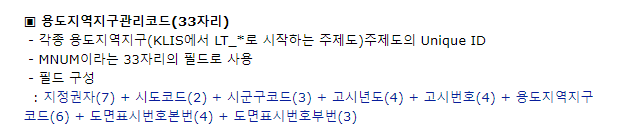

In [138]:
use_area = gpd.read_file('./data/9.4개시도_용도지역도.geojson')
# 실면적 구하기
use_area['area'] =use_area['geometry'].to_crs({'init': 'epsg:6933'})\
               .map(lambda p: p.area / 10**6 ) 
# use_area['SGG_OID'] =  use_area['SGG_OID'].astype('int64')
use_area.head()

MNUM      ALIAS REMARK   NTFDATE  SGG_OID  \
0  61100001111020090465UQA1210001001  제1종일반주거지역   None  20091119   4497.0   
1  15000001111020030040UQA1210001001       None   None      None   1297.0   
2  15000001111020000000UQA2200015000       None   None      None    632.0   
3  15000001111020080005UQA1220001001       None   None      None    634.0   
4  15000001111020000000UQA1300060000       None   None      None    635.0   

  COL_ADM_SE                                           geometry      area  
0      11110  MULTIPOLYGON (((126.96093 37.57299, 126.96094 ...  0.203807  
1      11110  MULTIPOLYGON (((126.95333 37.60132, 126.95356 ...  1.195412  
2      11110  MULTIPOLYGON (((127.00407 37.58753, 127.00413 ...  0.003136  
3      11110  MULTIPOLYGON (((127.00611 37.58416, 127.00614 ...  0.017285  
4      11110  MULTIPOLYGON (((126.97585 37.56949, 126.97588 ...  0.015041

In [139]:
# 상단 이미지의 설명에 따라 MNUM을 슬라이싱 
use_area['ADM_SECT_C'] = use_area['MNUM'].apply(lambda x : str(x)[7:12]) # 시도,군구코드
use_area['use_cd'] = use_area['MNUM'].apply(lambda x : x[-13:-7]) # 용도지역지구코드
code_nm = pd.read_excel('./data/코드정의서.xlsx', header=960) # 용도지역지구구분코드를 읽기 위해 불러옴
code_nm.head(3)

코드              코드명
0  UNIM04        비행안전 제4구역
1  UHK100           일반물류단지
2  UMK400  (한강)건축 등 허가제한지역

In [140]:
drop_idx = np.arange(1164, len(code_nm))
code_nm.drop(drop_idx, inplace=True)

In [141]:
# 코드정의서에 따라 용도지역구분코드명을 도출해 봅시다
code_dict = code_nm.set_index('코드').to_dict()['코드명'] # code name to dictionary
use_area['use_nm'] = use_area['use_cd'].apply(lambda x: code_dict[x] if x in code_dict.keys() else x)
use_area['use_nm'].value_counts()

생산관리지역       4454
보전관리지역       3070
제2종일반주거지역    2984
계획관리지역       2376
제1종일반주거지역    1798
농림지역         1433
제3종일반주거지역    1037
자연녹지지역        955
준주거지역         763
일반상업지역        478
생산녹지지역        103
보전녹지지역         81
준공업지역          72
일반공업지역         70
근린상업지역         68
제1종전용주거지역      62
제2종전용주거지역      35
유통상업지역         15
일반주거지역         11
UQA500          9
자연환경보전지역        7
중심상업지역          7
UQB000          4
전용주거지역          3
UQA999          2
Name: use_nm, dtype: int64

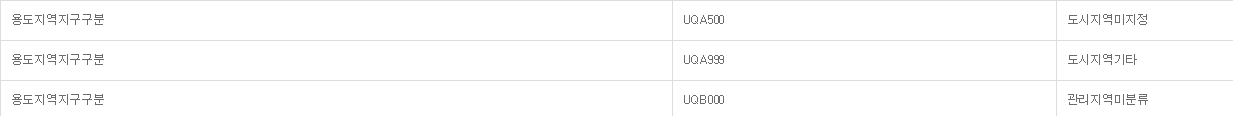
#### 콤파스 데이터의 코드정의서로 매칭에 실패한 code가 3종이 나왔다(UQA500/UQB000/UQA999)
이 3종은 행정표준코드관리시스템을 참조하여 채워주자.(참조사이트링크 <a href="https://www.code.go.kr/cod/frt/selectTotCdMeanList.do;jsessionid=B7Ft263pv9bhkAjkU6uIUIZt.CODserver1?pageIndex=17056">바로가기</a>)

In [142]:
add_code = {
    'UQA500' : '도시지역미지정',
    'UQB000' : '도시지역기타',
    'UQA999' : '관리지역미분류'
} # 행정표준코드관리시스템에서 찾은 3개의 코드네임으로 변경해주기
use_area['use_nm'] = use_area['use_nm'].apply(lambda x: add_code[x] if x in add_code.keys() else x)

In [143]:
# len(use_area)
# use_area.head()

#### 시군구 경계 데이터를 가져와서 각 용도지역에 시, 군, 구를 매칭해보자 ! 

In [144]:
seoul_area = gpd.GeoDataFrame.from_file('data/LARD_ADM_SECT_SGG_11.shp', encoding='cp949')
seoul_area = seoul_area.to_crs({'init':'epsg:4326'}) # 좌표계 epsg : 4326
kk_area = gpd.GeoDataFrame.from_file('data/LARD_ADM_SECT_SGG_41.shp', encoding='cp949')
kk_area = kk_area.to_crs({'init':'epsg:4326'}) # 좌표계 epsg : 4326
suwon_area = kk_area[kk_area['SGG_NM'].str.contains('수원')]
kn_area = gpd.GeoDataFrame.from_file('data/LARD_ADM_SECT_SGG_48.shp', encoding='cp949')
kn_area = kn_area.to_crs({'init':'epsg:4326'}) # 좌표계 epsg : 4326
changwon_jinju_area = kn_area[kn_area['ADM_SECT_C'].isin(['48170', '48127', '48121', '48129', '48125', '48123'])]

In [145]:
total_area = pd.concat([suwon_area, changwon_jinju_area, seoul_area]) # 서울, 수원, 창원, 진주 전체
# 시군구 실면적
total_area['total_area'] = total_area['geometry'].to_crs({'init': 'epsg:6933'})\
               .map(lambda p: p.area / 10**6 ) 

In [146]:
border_df = total_area[['ADM_SECT_C','SGG_NM', 'total_area']]
# border_df['COL_ADM_SE'] = border_df['COL_ADM_SE'].astype('int64')
# use_area = use_area.rename(columns = {'COL_ADM_SE' : 'ADM_SECT_C'})
use_area_df = pd.merge(border_df, use_area, on='ADM_SECT_C', how='outer') # 시군구 코드(ADM_SECT_C)를 기준으로 맞춰보았다
use_area_df.head()

ADM_SECT_C  SGG_NM  total_area                               MNUM ALIAS  \
0      41115  수원시팔달구   13.097981  15000004111500000000UQA1220000072  None   
1      41115  수원시팔달구   13.097981  15000004111500000000UQA1300000053  None   
2      41115  수원시팔달구   13.097981  15000004111500000000UQA1220000074  None   
3      41115  수원시팔달구   13.097981  15000004111500000000UQA1220000045  None   
4      41115  수원시팔달구   13.097981  15000004111500000000UQA1220000035  None   

  REMARK NTFDATE  SGG_OID COL_ADM_SE  \
0   None    None   1541.0      41110   
1   None    None   1203.0      41110   
2   None    None   1216.0      41110   
3   None    None   1425.0      41110   
4   None    None   1374.0      41110   

                                            geometry      area  use_cd  \
0  MULTIPOLYGON (((127.03326 37.26716, 127.03318 ...  0.000349  UQA122   
1  MULTIPOLYGON (((127.04387 37.27612, 127.04394 ...  0.032812  UQA130   
2  MULTIPOLYGON (((127.00184 37.26466, 127.00218 ...  0.061422  UQA122   
3  MULTIPOLYGON (((127.02906 37.27872, 127.02901 ...  0.036255  UQA122   
4  MULTIPOLYGON (((126.99806 37.28352, 126.99849 ...  0.000643  UQA122   

      use_nm  
0  제2종일반주거지역  
1      준주거지역  
2  제2종일반주거지역  
3  제2종일반주거지역  
4  제2종일반주거지역

In [147]:
# 41110 : 수원시, 48120 : 창원시 가 빈 값으로 나와버렸다
use_area_df[use_area_df['SGG_NM'].isnull()]['ADM_SECT_C'].unique() 

array(['41110', '48120'], dtype=object)

In [148]:
len(use_area_df[use_area_df['SGG_NM'].isnull()]['ADM_SECT_C']) # 수원, 창원이 총 4131개!

4131

In [149]:
## 남은 것(수원, 창원 데이터)들은 geometry 기반으로 재 매칭 해주자.
def suwon_gu_name(geometry) :
    for i in range(len(suwon_area['SGG_NM'].unique())) :    
        if geometry.within(suwon_area.iloc[i].geometry) :             
            return suwon_area.iloc[i].SGG_NM    
        
def changwon_gu_name(geometry) :
    for i in range(len(changwon_jinju_area['SGG_NM'].unique())) :    
        if geometry.within(changwon_jinju_area.iloc[i].geometry) :             
            return changwon_jinju_area.iloc[i].SGG_NM    

In [150]:
# 위에서 정의한 함수 적용!
use_area_df['SGG_NM'] = use_area_df.progress_apply(lambda x : suwon_gu_name(x['geometry']) if x['ADM_SECT_C']=='41110' else x['SGG_NM'], axis=1)
use_area_df['SGG_NM'] = use_area_df.progress_apply(lambda x : changwon_gu_name(x['geometry']) if x['ADM_SECT_C']=='48120' else x['SGG_NM'], axis=1)

100%|██████████| 19897/19897 [00:33<00:00, 587.57it/s]  


In [151]:
# 경계선에 걸치는 지역들이 일부 누락되었다. (확인)
len(use_area_df[use_area_df['SGG_NM'].isnull()]) 

439

In [152]:
# gpd.GeoDataFrame(use_area_df[use_area_df['SGG_NM'].isnull()]).head(3) 확인 차 출력해봄

In [153]:
# 누락된 경계값들은 overlay로 다시 매칭해주자.
suwon_overlay = gpd.overlay(gpd.GeoDataFrame(use_area_df[use_area_df['SGG_NM'].isnull()])[['geometry','use_nm']], suwon_area, how='intersection')
changwon_overlay = gpd.overlay(gpd.GeoDataFrame(use_area_df[use_area_df['SGG_NM'].isnull()])[['geometry','use_nm']], changwon_jinju_area, how='intersection')

In [154]:
area_df = pd.concat([use_area_df, suwon_overlay, changwon_overlay]).dropna(subset=['SGG_NM'])
use_area_df = area_df
use_area_df.head(3) # 매칭 최종 결과!

ADM_SECT_C  SGG_NM  total_area                               MNUM ALIAS  \
0      41115  수원시팔달구   13.097981  15000004111500000000UQA1220000072  None   
1      41115  수원시팔달구   13.097981  15000004111500000000UQA1300000053  None   
2      41115  수원시팔달구   13.097981  15000004111500000000UQA1220000074  None   

  REMARK NTFDATE  SGG_OID COL_ADM_SE  \
0   None    None   1541.0      41110   
1   None    None   1203.0      41110   
2   None    None   1216.0      41110   

                                            geometry      area  use_cd  \
0  MULTIPOLYGON (((127.03326 37.26716, 127.03318 ...  0.000349  UQA122   
1  MULTIPOLYGON (((127.04387 37.27612, 127.04394 ...  0.032812  UQA130   
2  MULTIPOLYGON (((127.00184 37.26466, 127.00218 ...  0.061422  UQA122   

      use_nm  GID  
0  제2종일반주거지역  NaN  
1      준주거지역  NaN  
2  제2종일반주거지역  NaN

In [155]:
use_area_df['area'] = gpd.GeoDataFrame(use_area_df)['geometry'].to_crs({'init': 'epsg:6933'})\
               .map(lambda p: p.area / 10**6 ) # 실면적

In [156]:
#  확인 차 출력해봄 . .
# total_area['SGG_NM'].unique() 
# use_area_df['SGG_NM'].unique() 

In [157]:
# 용지 종류 별 면적을 구하기 위해 실면적 데이터를 Merge !
use_area_df = pd.merge(use_area_df.drop(['total_area'],axis=1), total_area[['SGG_NM', 'total_area']] , on='SGG_NM')

In [158]:
pd.options.display.float_format = '{:.5f}'.format # 출력을 이쁘게..(소숫점 5자리까지)

In [159]:
use_area_df['use_nm'].unique()

array(['제2종일반주거지역', '준주거지역', '제3종일반주거지역', '자연녹지지역', '제1종일반주거지역', '일반상업지역',
       '근린상업지역', '보전녹지지역', '중심상업지역', '생산녹지지역', '일반공업지역', '준공업지역',
       '제1종전용주거지역', '유통상업지역', '보전관리지역', '생산관리지역', '계획관리지역', '도시지역기타',
       '농림지역', '자연환경보전지역', '도시지역미지정', '제2종전용주거지역', '관리지역미분류', '전용주거지역',
       '일반주거지역'], dtype=object)

### 용지 종류가 상세하게 되어 있어서(총 25종 !) 편의상 비슷한 용지 끼리 묶어서 재분류 해 보았다.
1. <strong>녹지지역</strong> : '계획관리지역', '자연환경보전지역', '보전관리지역', '~ 녹지지역'
2. <strong>주거지역</strong> : '~ 주거지역'
3. <strong>농경지역</strong> : '농림지역', '생산관리지역'
4. <strong>상업지역</strong> : '~ 상업지역'
5. <strong>공업지역</strong> : '~ 공업지역'
6. <strong>기타</strong> : 미지정, 기타

In [160]:
## 상단의 카테고리로 재분류!
use_area_df['use_cat'] = use_area_df['use_nm'].apply(lambda x : '녹지지역' if '녹지' in x or x in ['계획관리지역', '자연환경보전지역', '보전관리지역' ] else x)
use_area_df['use_cat'] = use_area_df['use_cat'].apply(lambda x : '주거지역' if '주거' in x else x)
use_area_df['use_cat'] = use_area_df['use_cat'].apply(lambda x : '농경지역' if x in ['농림지역', '생산관리지역'] else x)
use_area_df['use_cat'] = use_area_df['use_cat'].apply(lambda x : '상업지역' if '상업' in x else x)
use_area_df['use_cat'] = use_area_df['use_cat'].apply(lambda x : '공업지역' if '공업' in x else x)
use_area_df['use_cat'] = use_area_df['use_cat'].apply(lambda x : '기타' if x in ['도시지역미지정', '관리지역미분류', '도시지역기타'] else x)
use_area_df.drop_duplicates(subset='geometry', inplace=True)

### 분류한 이후에는 용지 종류별로 총 면적을 SUM 해보자.

In [161]:
use_area_sum = use_area_df.groupby(['SGG_NM','use_cat']).sum().reset_index()[['SGG_NM', 'use_cat',  'area']]
use_area_sum.head()

SGG_NM use_cat     area
0    강남구    녹지지역 13.57398
1    강남구    상업지역  1.94650
2    강남구    주거지역 16.11766
3    강동구    공업지역  0.07814
4    강동구      기타  0.24805

In [162]:
# 창원시 구 전체
changwon_total = use_area_sum[use_area_sum['SGG_NM'].str.contains('창원')].groupby('use_cat').sum().reset_index()
changwon_total['SGG_NM'] = '창원시'

# 수원시 구 전체
suwon_total = use_area_sum[use_area_sum['SGG_NM'].str.contains('수원')].groupby('use_cat').sum().reset_index()
suwon_total['SGG_NM'] = '수원시'

In [163]:
use_area_sum = pd.concat([use_area_sum, changwon_total, suwon_total]) # 종합

In [164]:
# 시,군,구의 전체면적 데이터를 Merge하자(면적 대비 용지 지역도를 보기 위함)
area_con = pd.merge(use_area_sum, total_area[['SGG_NM','total_area']], how='outer')
# Null 값(창원시 전체, 수원시 전체)을 확인 ! 
area_con[area_con['total_area'].isnull()]

SGG_NM use_cat      area  total_area
134    창원시    공업지역  41.26837         nan
135    창원시      기타   8.22226         nan
136    창원시    녹지지역 442.14136         nan
137    창원시    농경지역 193.68568         nan
138    창원시    상업지역   9.44657         nan
139    창원시    주거지역  59.67301         nan
140    수원시    공업지역   4.35136         nan
141    수원시    녹지지역  81.07507         nan
142    수원시    상업지역   5.91275         nan
143    수원시    주거지역  45.91470         nan

In [165]:
# Null 값을 채워주기 위해서 창원의 5개구, 수원의 5개구의 SUM 값을 입력한다.
c_idx = area_con[area_con['SGG_NM']=='창원시'].index
s_idx = area_con[area_con['SGG_NM']=='수원시'].index
for i,j in zip(c_idx, s_idx) : # fillNa
    area_con.loc[c_idx, 'total_area'] = total_area[total_area['SGG_NM'].str.contains('창원')]['total_area'].sum()
    area_con.loc[s_idx, 'total_area'] = total_area[total_area['SGG_NM'].str.contains('수원')]['total_area'].sum()    

In [166]:
# area_con['total_area'].fillna(total_area[total_area['SGG_NM'].str.contains('창원')]['total_area'].sum(), inplace=True) # 창원 전체면적

### 총 면적 대비 용도 면적의 비율을 산정하자
- 면적에 대한 비율을 산정하지 않으면 절대적인 면적이 큰 시,군, 구 단위로 인해 정확한 분석에 어려움을 겪을 수 있다.
- 용도면적 비율(use_ratio) => 총면적(area) / 전체면적(total_area) 으로 계산

In [167]:
# 용도지역 면적 비율 넣기
area_con['use_ratio'] = area_con['area'] / area_con['total_area']
area_con.head(3)

SGG_NM use_cat     area  total_area  use_ratio
0    강남구    녹지지역 13.57398    39.49645    0.34368
1    강남구    상업지역  1.94650    39.49645    0.04928
2    강남구    주거지역 16.11766    39.49645    0.40808

In [168]:
# ratio > 1 값 변환(일부 지역 ratio가 1.0이 넘어가는 곳이 있어서,)
temp = area_con.groupby(['SGG_NM']).sum().reset_index()
temp = temp[temp['use_ratio'] > 1]
temp['sub_ratio'] = temp['use_ratio'] - 1
temp_dict = temp.set_index('SGG_NM').to_dict()['sub_ratio']
temp_dict

{'강동구': 0.020074320517627697,
 '강북구': 0.0016098329190374905,
 '강서구': 0.019512598349581856,
 '관악구': 4.255748554227168e-06,
 '광진구': 0.004321899209797975,
 '구로구': 0.0006491066944867008,
 '금천구': 2.641068422581938e-05,
 '동대문구': 0.00404968201688094,
 '동작구': 0.005475569090241272,
 '마포구': 0.0007858771439552825,
 '서대문구': 0.004379995586720753,
 '서울시노원구': 0.0003254601055928674,
 '서울시도봉구': 0.0004658245672670702,
 '서울시성북구': 0.0008934483027864815,
 '서초구': 0.0010790048766526894,
 '성동구': 0.0031999993165463536,
 '송파구': 0.00011776292689225087,
 '수원시': 0.1331156332144494,
 '수원시권선구': 0.28818877474835203,
 '수원시영통구': 0.08144400402877738,
 '수원시장안구': 0.002986325016590907,
 '수원시팔달구': 0.010245902442800325,
 '양천구': 0.00943792337802929,
 '영등포구': 0.01225456134342684,
 '용산구': 0.004179949238200198,
 '은평구': 0.0004986756097895562,
 '중구': 0.0027843781434537807,
 '진주시': 0.00024335882929538144,
 '창원시': 0.009695112948564288,
 '창원시마산회원구': 0.03846750114251618,
 '창원시성산구': 0.2931533044346806}

In [169]:
# 해당 지역들(ratio 총합 > 1.0)의 녹지지역에 - 연산 해줌
area_con['use_ratio'] = area_con.apply(lambda x : x['use_ratio'] - temp_dict[x['SGG_NM']] if x['SGG_NM'] in temp_dict.keys() and x['use_cat']=='녹지지역' else x['use_ratio'] ,axis=1)

In [170]:
# !pip install --upgrade pip
# !pip install plotly
# !pip install cufflinks
# !pip install chart_studio

### ** 행정구역별 용지지역 비율(시각화)

In [171]:
import plotly.express as px
title={'text': "행정구역 별 용도지역 비율",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}


long_df = px.data.medals_long()
fig = px.bar(area_con, x="SGG_NM", y="use_ratio", color="use_cat", title="Long-Form Input")

fig.update_layout(
#     autosize=False,
#     width=500,
#     height=500,
    title=title)  # fig size 조정
fig.show()

#### 상단에 정의한 카테고리 타입별로 일련의 column을 생성하여, 구해놓은 용지지역 비율 값을 넣어보자

In [172]:
temp_data = area_con[['SGG_NM','total_area']].drop_duplicates(subset='SGG_NM')
for i in area_con['use_cat'].unique() :
    temp_data[i+ '_use_ratio'] = 0
temp_data.head(3)

SGG_NM  total_area  녹지지역_use_ratio  상업지역_use_ratio  주거지역_use_ratio  \
0    강남구    39.49645               0               0               0   
3    강동구    24.55662               0               0               0   
8    강북구    23.63614               0               0               0   

   공업지역_use_ratio  기타_use_ratio  농경지역_use_ratio  
0               0             0               0  
3               0             0               0  
8               0             0               0

In [173]:
for i in range(len(area_con)) :
    temp_name = area_con.loc[i, 'use_cat']
    temp = temp_data[temp_data['SGG_NM']==area_con['SGG_NM'].iloc[i]]
    temp[temp_name] = area_con['use_ratio'].iloc[i]
    temp_data.loc[temp.index , temp_name+'_use_ratio'] = area_con[area_con['use_cat']==temp_name].loc[i, 'use_ratio']
temp_data.head(3)

SGG_NM  total_area  녹지지역_use_ratio  상업지역_use_ratio  주거지역_use_ratio  \
0    강남구    39.49645         0.34368         0.04928         0.40808   
3    강동구    24.55662         0.42942         0.02800         0.52930   
8    강북구    23.63614         0.52576         0.01182         0.46242   

   공업지역_use_ratio  기타_use_ratio  농경지역_use_ratio  
0         0.00000       0.00000         0.00000  
3         0.00318       0.01010         0.00000  
8         0.00000       0.00000         0.00000

In [174]:
temp_data.to_csv('./data/구별용도지역도.csv', encoding='euc-kr') # 중간SAVE
use_area_ratio = temp_data

## <2> 토지이용계획도

In [175]:
land_plan = gpd.read_file('./data/41.4개시도_토지이용계획도.geojson')
# land_plan['BLOCKTYPE'].value_counts()

In [176]:
# ZONECODE에서 시군구 코드 추출하기
land_plan['sgg_cd'] = land_plan['ZONECODE'].apply(lambda x: x[:5])
land_plan['sgg_cd'].nunique()

32

In [177]:
len(land_plan) # 총 row 수 확인

9911

In [178]:
df = pd.merge(total_area.rename(columns={'ADM_SECT_C' :'sgg_cd'}).drop(['geometry'],axis=1), land_plan, on='sgg_cd', how='outer')
df[df['SGG_NM'].isnull()]['sgg_cd'].unique() # 매칭 안된 sgg_cd

array(['41463', '48110', '48120', '48160', '48190', '41310', '41281',
       '28245', '41210', '41190', '41197', '41290', '41450'], dtype=object)

In [179]:
df.drop(df[df['SGG_NM'].isnull()].index, inplace=True) # drop NA

In [180]:
# 시군구 매칭
land_plan_df = gpd.overlay(land_plan, total_area, how='intersection')
land_plan_df.head(3)

ORG_GID BLOCKTYPE BLOCKNAME        ZONECODE ZONENAME sgg_cd ADM_SECT_C  \
0 9104.00000      완충녹지         완  41111KL1994002    수원천천2  41111      41111   
1 9105.00000       유치원         유  41111KL1994002    수원천천2  41111      41111   
2 9106.00000       유치원         유  41111KL1994002    수원천천2  41111      41111   

   SGG_NM  SGG_OID COL_ADM_SE  GID  total_area  \
0  수원시장안구     1649      41110  243    33.15086   
1  수원시장안구     1649      41110  243    33.15086   
2  수원시장안구     1649      41110  243    33.15086   

                                            geometry  
0  POLYGON ((126.97332 37.30315, 126.97324 37.303...  
1  POLYGON ((126.98477 37.29347, 126.98464 37.293...  
2  POLYGON ((126.97947 37.29877, 126.97941 37.298...

In [181]:
land_plan_df['SGG_NM'].nunique()

27

In [182]:
land_plan_df['area'] = land_plan_df['geometry'].to_crs({'init': 'epsg:6933'})\
               .map(lambda p: p.area / 10**6 ) # 실면적 구하기!

In [183]:
land_plan_df['BLOCKTYPE'].nunique()

147

### 이용계획도 용지가 상세하게 되어 있어서(총147종 !) 편의상 비슷한 용지 끼리 묶어서 재분류 해 보았다.
<sub>(각 카테고리에 해당하는 값은 하단 코드에서 정리)</sub>
1. <strong>주거용지</strong>
2. <strong>녹지</strong> 
3. <strong>공원용지</strong> 
4. <strong>학교용지</strong> 
5. <strong>도로용지</strong> 
6. <strong>상업용지</strong> 
7. <strong>공공용지</strong>
8. <strong>업무용지</strong>
9. <strong>시설용지</strong>

In [184]:
# 주거용지 분류
house_area = land_plan_df[land_plan_df['BLOCKTYPE'].isin(['공동주택', '단독주택', '단독주택기타', '도시형생활주택용지', '다세대주택', '연립주택', '아파트', '아파트기타'])]
house_area['area_nm'] = '주거용지'
# 녹지 분류
green_area = land_plan_df[land_plan_df['BLOCKTYPE'].isin(['완충녹지', '녹지', '경관녹지', '연결녹지', '녹지기타', '공원녹지'])]
green_area['area_nm'] = '녹지'
# 공원용지분류
park_area = land_plan_df[land_plan_df['BLOCKTYPE'].isin(['근린공원', '공원', '어린이공원', '수변공원', '소공원', '문화공원', '체육공원', '도시자연공원',
       '역사공원', '공원녹지', '공원기타'])]
park_area['area_nm'] = '공원용지'
# 학교용지분류
school_area  = land_plan_df[land_plan_df['BLOCKTYPE'].isin(['학교', '고등학교', '초등학교', '중학교', '학교기타', '교육시설', '청소년수련시설'])]
school_area['area_nm'] = '학교용지'
# 도로용지분류
load_area = land_plan_df[land_plan_df['BLOCKTYPE'].isin(['자전거전용도로', '보행자전용도로', '도로'])]
load_area['area_nm'] = '도로용지'
# 상업용지분류
comm_area = land_plan_df[land_plan_df['BLOCKTYPE'].isin(['상업용지', '상업시설', '근린상업', '일반상업', '중심상업', '숙박시설', '숙박시설기타', '판매및영업시설', '종합의료시설'])]
comm_area['area_nm'] = '상업용지'
# 공공용지분류
public_area = land_plan_df[land_plan_df['BLOCKTYPE'].isin(['공공청사', '공공공지', '공공공지기타', '공공문화체육기타', '이전공공기관', '근린공공시설', '공공보육시설',
       '공공청사기타', '사회복지시설', '사회복지시설기타'])]
comm_area['area_nm'] = '공공용지'
# 업무,산업,공업용지분류
business_area = land_plan_df[land_plan_df['BLOCKTYPE'].isin(['업무시설', '유통업무시설', '산업용지', '산업시설기타', '벤처및공업용지'])]
business_area['area_nm'] = '업무용지'
# 시설용지분류
facility_area = land_plan_df[land_plan_df['BLOCKTYPE'].isin(['유수시설', '자원재활용시설','폐기물처리시설','하수종말처리시설','폐수종말처리시설',
       '연구시설기타', '저류시설', '배수시설', '위험물저장및처리시설', '변전시설'])]
facility_area['area_nm'] = '시설용지'

### 분류한 이후에는 용지 종류별로 총 면적을 SUM 해보자.

In [185]:
plan_area = pd.concat([house_area, green_area, park_area, school_area, load_area, comm_area, public_area, business_area, facility_area])
plan_area_sum = plan_area.groupby(['SGG_NM','area_nm']).sum().reset_index()[['SGG_NM','area_nm', 'area']].rename(columns={'SGG_NM' : 'sgg_nm'})
plan_area_sum.head(3)

sgg_nm area_nm    area
0    강남구    공공용지 0.10265
1    강남구    공원용지 0.77043
2    강남구      녹지 0.38498

In [186]:
# 창원시 구 전체
changwon_plan_area_sum = plan_area_sum[plan_area_sum['sgg_nm'].str.contains('창원')].groupby('area_nm').sum().reset_index()
changwon_plan_area_sum['sgg_nm'] = '창원시'

# 수원시 구 전체
suwon_plan_area_sum = plan_area_sum[plan_area_sum['sgg_nm'].str.contains('수원')].groupby('area_nm').sum().reset_index()
suwon_plan_area_sum['sgg_nm'] = '수원시'


In [187]:
plan_area_sum = pd.concat([plan_area_sum, changwon_plan_area_sum, suwon_plan_area_sum])
plan_area_sum # 창원시 + 수원시 + 전체 시군구

sgg_nm area_nm    area
0     강남구    공공용지 0.10265
1     강남구    공원용지 0.77043
2     강남구      녹지 0.38498
3     강남구    도로용지 0.45636
4     강남구    시설용지 0.04315
..    ...     ...     ...
3     수원시    도로용지 7.25085
4     수원시    시설용지 0.23359
5     수원시    업무용지 0.15990
6     수원시    주거용지 7.62508
7     수원시    학교용지 1.18515

[195 rows x 3 columns]

In [188]:
plan_area_total = plan_area.groupby(['SGG_NM']).sum().reset_index()[['SGG_NM','area']].rename(columns={'SGG_NM' : 'sgg_nm', 'area' : 'plan_total_area' })

### 총 면적 대비 용도 면적의 비율을 산정하자
- 면적에 대한 비율을 산정하지 않으면 절대적인 면적이 큰 시,군, 구 단위로 인해 정확한 분석에 어려움을 겪을 수 있다.
- 계획용도면적 비율(plan_area_ratio) => 계획용도별 면적(total_area) / 계획용도지역전체면적(plan_total_area) 으로 계산

In [189]:
plan_area_total_df = pd.merge(plan_area_total, plan_area_sum, how='outer')
plan_area_total_df['plan_total_area'].fillna(plan_area_total[plan_area_total['sgg_nm'].str.contains('창원시')]['plan_total_area'].sum(), inplace=True)
plan_area_total_df['plan_area_ratio'] = plan_area_total_df['area'] / plan_area_total_df['plan_total_area']  * 100
plan_area_total_df.head()

sgg_nm  plan_total_area area_nm    area  plan_area_ratio
0    강남구          4.99367    공공용지 0.10265          2.05566
1    강남구          4.99367    공원용지 0.77043         15.42820
2    강남구          4.99367      녹지 0.38498          7.70928
3    강남구          4.99367    도로용지 0.45636          9.13885
4    강남구          4.99367    시설용지 0.04315          0.86412

In [190]:
# plan_area_total_df['sgg_nm'].unique() 확인

In [191]:
# ratio 컬럼 생성
temp_data = plan_area_total_df[['sgg_nm','plan_total_area']].drop_duplicates(subset='sgg_nm')
for i in plan_area_total_df['area_nm'].unique() :
    temp_data[i+ '_plan_use_ratio'] = 0
temp_data.head(3)

sgg_nm  plan_total_area  공공용지_plan_use_ratio  공원용지_plan_use_ratio  \
0     강남구          4.99367                    0                    0   
8     강동구          6.25774                    0                    0   
15    강북구          0.35194                    0                    0   

    녹지_plan_use_ratio  도로용지_plan_use_ratio  시설용지_plan_use_ratio  \
0                   0                    0                    0   
8                   0                    0                    0   
15                  0                    0                    0   

    업무용지_plan_use_ratio  주거용지_plan_use_ratio  학교용지_plan_use_ratio  
0                     0                    0                    0  
8                     0                    0                    0  
15                    0                    0                    0

In [192]:
# 컬럼별 값 채워주기
for i in range(len(plan_area_total_df)) :
    temp_name = plan_area_total_df.loc[i, 'area_nm']
    temp = temp_data[temp_data['sgg_nm']==plan_area_total_df['sgg_nm'].iloc[i]]
    temp[temp_name] = plan_area_total_df['plan_area_ratio'].iloc[i]
    temp_data.loc[temp.index , temp_name+'_plan_use_ratio'] = plan_area_total_df[plan_area_total_df['area_nm']==temp_name].loc[i, 'plan_area_ratio']
temp_data.head(3)

sgg_nm  plan_total_area  공공용지_plan_use_ratio  공원용지_plan_use_ratio  \
0     강남구          4.99367              2.05566             15.42820   
8     강동구          6.25774              2.04362             26.28500   
15    강북구          0.35194              0.00000              3.64085   

    녹지_plan_use_ratio  도로용지_plan_use_ratio  시설용지_plan_use_ratio  \
0             7.70928              9.13885              0.86412   
8             3.07211             15.14485              0.73526   
15            3.13509              9.47122              0.00000   

    업무용지_plan_use_ratio  주거용지_plan_use_ratio  학교용지_plan_use_ratio  
0               1.52115             55.06693              6.91874  
8               0.00000             46.16517              5.83226  
15              0.00000             72.44758             10.36142

In [193]:
plan_area_ratio = temp_data
# plan_area_ratio['sgg_nm'].unique() 확인

In [194]:
use_area_ratio['SGG_NM'].nunique()

37

#### 용도지역도와 토지이용계획도를 Merge 하여 줍니다,

In [195]:
area_ratio_total = pd.merge(use_area_ratio.rename(columns={'SGG_NM' : 'sgg_nm'}), plan_area_ratio)
area_ratio_total.head() # 용도지역도와 토지이용계획도 Merge

sgg_nm  total_area  녹지지역_use_ratio  상업지역_use_ratio  주거지역_use_ratio  \
0    강남구    39.49645         0.34368         0.04928         0.40808   
1    강동구    24.55662         0.42942         0.02800         0.52930   
2    강북구    23.63614         0.52576         0.01182         0.46242   
3    강서구    41.41618         0.52376         0.03196         0.37377   
4    관악구    29.56301         0.46834         0.01331         0.51834   

   공업지역_use_ratio  기타_use_ratio  농경지역_use_ratio  plan_total_area  \
0         0.00000       0.00000         0.00000          4.99367   
1         0.00318       0.01010         0.00000          6.25774   
2         0.00000       0.00000         0.00000          0.35194   
3         0.07051       0.00000         0.00000          6.38541   
4         0.00000       0.00000         0.00000          0.05091   

   공공용지_plan_use_ratio  공원용지_plan_use_ratio  녹지_plan_use_ratio  \
0              2.05566             15.42820            7.70928   
1              2.04362             26.28500            3.07211   
2              0.00000              3.64085            3.13509   
3              3.34507             15.98237            4.17264   
4              0.00000              5.26184            0.27179   

   도로용지_plan_use_ratio  시설용지_plan_use_ratio  업무용지_plan_use_ratio  \
0              9.13885              0.86412              1.52115   
1             15.14485              0.73526              0.00000   
2              9.47122              0.00000              0.00000   
3             18.86476             11.73662              4.81932   
4             14.37564              0.00000              0.00000   

   주거용지_plan_use_ratio  학교용지_plan_use_ratio  
0             55.06693              6.91874  
1             46.16517              5.83226  
2             72.44758             10.36142  
3             31.94923              6.72186  
4             80.00236              0.00000

In [196]:
# area_ratio_total['sgg_nm'].unique() 확인

In [197]:
area_ratio_total.to_csv('./data/4개시군구_용도지역_토지이용계획도.csv')

## <3> 주택노후도

In [198]:
house_old_con = gpd.read_file('./data/7.4개시도_주택노후도.geojson')
house_old_con.head()

ORG_GID BLD_NM DONG_NM                  PNU  STRCT_NM     USE_NM  \
0 704627.00000   None    None  1111017500107040000     기타강구조       단독주택   
1 704628.00000   None    None  1111017500100560024      벽돌구조       단독주택   
2 704629.00000   None    None  1111017500100560054      벽돌구조       단독주택   
3 704630.00000   None    None  1111017500100560053      벽돌구조       단독주택   
4 704632.00000   None    None  1111016500100280041  철근콘크리트구조  제2종근린생활시설   

  USEAPR_DAY  OLD_YEAR  OLD_LEVEL  \
0   19910902  30.00000    4.00000   
1   19670528  54.00000    4.00000   
2   19621221  58.00000    4.00000   
3   19790601  42.00000    4.00000   
4   19940425  27.00000    3.00000   

                                            geometry  
0  MULTIPOLYGON (((127.02166 37.57731, 127.02165 ...  
1  MULTIPOLYGON (((127.01600 37.57725, 127.01596 ...  
2  MULTIPOLYGON (((127.01633 37.57723, 127.01633 ...  
3  MULTIPOLYGON (((127.01651 37.57717, 127.01646 ...  
4  MULTIPOLYGON (((127.00532 37.57728, 127.00534 ...

In [199]:
house_old_con['area'] = house_old_con['geometry'].to_crs({'init': 'epsg:6933'})\
               .map(lambda p: p.area / 10**6 )  # 실면적 Add

In [200]:
house_old_con['geometry'] = house_old_con.centroid # geometry의 중심점

<center>**PNU의 정의**</center>

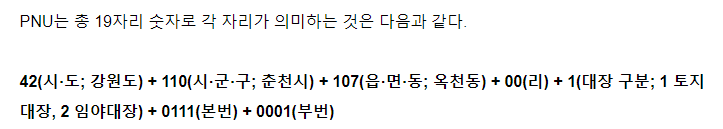

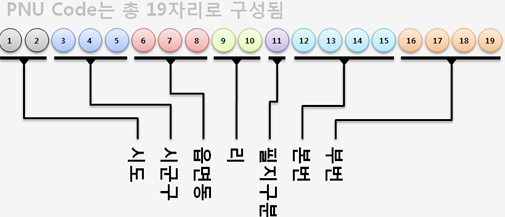

- <mark>PNU</mark>에서 법정동코드를 추출하여 법정동명과 매칭합니다
- 법정동코드으로 법정동명을 매칭하는 데이터 <a href="https://www.data.go.kr/data/15029071/standard.do">개별공시지가정보서비스.zip 다운로드</a>

In [201]:
dong_cd = pd.read_excel('./data/행정구역코드(법정동코드).xls')
dong_cd.head(3)

법정동코드           법정동명 폐지여부
0  1100000000          서울특별시   존재
1  1111000000      서울특별시 종로구   존재
2  1111010100  서울특별시 종로구 청운동   존재

In [202]:
 # PNU에서 법정동코드 추출하기(x[:10]으로 슬라이스)
house_old_con['법정동코드'] = house_old_con['PNU'].apply(lambda x : int(x[:10]))
house_old_df = pd.merge(dong_cd[['법정동코드','법정동명']], house_old_con)
house_old_df.head(2) # 법정동코드 기준으로 Merge

법정동코드           법정동명      ORG_GID BLD_NM DONG_NM                  PNU  \
0  1111010100  서울특별시 종로구 청운동 706700.00000   None    None  1111010100100550014   
1  1111010100  서울특별시 종로구 청운동 725027.00000   None    None  1111010100100890015   

   STRCT_NM     USE_NM USEAPR_DAY  OLD_YEAR  OLD_LEVEL  \
0      벽돌구조  제2종근린생활시설   19890919  31.00000    4.00000   
1  철근콘크리트구조       단독주택   19970820  24.00000    3.00000   

                     geometry    area  
0  POINT (126.96626 37.58675) 0.00020  
1  POINT (126.97197 37.58590) 0.00023

In [203]:
# 법정동에서 서울은 구단위, 그 외는 시 단위로 슬라이싱
house_old_df['sgg_nm'] = house_old_df['법정동명'].apply(lambda x: x.split(' ')[1])
house_old_df['sgg_nm'].unique()

array(['종로구', '중구', '용산구', '성동구', '광진구', '동대문구', '중랑구', '성북구', '강북구',
       '도봉구', '노원구', '은평구', '서대문구', '마포구', '양천구', '강서구', '구로구', '금천구',
       '영등포구', '동작구', '관악구', '서초구', '강남구', '송파구', '강동구', '수원시', '창원시',
       '진주시'], dtype=object)

In [204]:
house_old_df['sgg_nm'] = house_old_df.apply(lambda x: x['법정동명'].split(' ')[2] if '수원시' in x['법정동명'] else x['sgg_nm'], axis=1)
house_old_df['sgg_nm'] = house_old_df.apply(lambda x: x['법정동명'].split(' ')[2] if '창원시' in x['법정동명'] else x['sgg_nm'], axis=1)
house_old_df['sgg_nm'].value_counts().head()
# house_old_df['sgg_nm'].value_counts().head(5)

진주시     46507
관악구     31856
성북구     30720
동대문구    29371
은평구     29063
Name: sgg_nm, dtype: int64

In [205]:
# house_old_df['sgg_nm'].unique() 확인

### 주택노후도 level별 area 구하기
#### 시,군,구 별 old_level(1~4단계)에 대한 총 면적을 산출합니다.

In [206]:
old_level_sum = house_old_df.groupby(['sgg_nm','OLD_LEVEL']).sum().reset_index()[['sgg_nm','OLD_LEVEL','area']]
old_level_sum.head()

sgg_nm  OLD_LEVEL    area
0    강남구    1.00000 0.10272
1    강남구    2.00000 1.58321
2    강남구    3.00000 1.84929
3    강남구    4.00000 2.25640
4    강동구    1.00000 0.44948

In [207]:
temp_data = old_level_sum[['sgg_nm']].drop_duplicates()
for i in old_level_sum['OLD_LEVEL'].unique() :
    temp_data['area_old_level_'+str(i)[0]] = 0
temp_data.head(3)

sgg_nm  area_old_level_1  area_old_level_2  area_old_level_3  \
0    강남구                 0                 0                 0   
4    강동구                 0                 0                 0   
8    강북구                 0                 0                 0   

   area_old_level_4  
0                 0  
4                 0  
8                 0

In [208]:
# old level 1~ 4 면적 컬럼별로 값 넣기 
for i in range(len(old_level_sum)) :
    temp_name = old_level_sum.loc[i, 'OLD_LEVEL']
    temp = temp_data[temp_data['sgg_nm']==old_level_sum['sgg_nm'].iloc[i]]
    temp[temp_name] = old_level_sum['area'].iloc[i]
    temp_data.loc[temp.index , 'area_old_level_'+str(temp_name)[0]] = old_level_sum[old_level_sum['OLD_LEVEL']==temp_name].loc[i, 'area']
temp_data.head(3)

sgg_nm  area_old_level_1  area_old_level_2  area_old_level_3  \
0    강남구           0.10272           1.58321           1.84929   
4    강동구           0.44948           0.82360           0.73865   
8    강북구           0.32225           0.57927           0.92802   

   area_old_level_4  
0           2.25640  
4           1.36019  
8           1.46886

In [209]:
# temp_data[temp_data['sgg_nm'].isin(['의창구', '성산구', '마산합포구', '마산회원구', '진해구'])].iloc[:,1:]

In [210]:
# 창원시, 수원시 데이터 만들기
changwon_ = pd.DataFrame(temp_data[temp_data['sgg_nm'].isin(['의창구', '성산구', '마산합포구', '마산회원구', '진해구'])].iloc[:,1:].sum()).T
changwon_['sgg_nm'] = '창원시'
suwon_ = pd.DataFrame(temp_data[temp_data['sgg_nm'].isin(['장안구', '권선구', '팔달구', '영통구'])].iloc[:,1:].sum()).T
suwon_['sgg_nm'] = '수원시'

In [211]:
# 창원시, 수원시와 시,군,구 데이터 Concat
old_level_total = pd.concat([temp_data, changwon_, suwon_])
old_level_total.head()

sgg_nm  area_old_level_1  area_old_level_2  area_old_level_3  \
0     강남구           0.10272           1.58321           1.84929   
4     강동구           0.44948           0.82360           0.73865   
8     강북구           0.32225           0.57927           0.92802   
12    강서구           0.27076           1.49532           1.59307   
16    관악구           0.40570           1.04620           1.36264   

    area_old_level_4  
0            2.25640  
4            1.36019  
8            1.46886  
12           1.55037  
16           1.59885

In [212]:
# old_level_total['sgg_nm'].nunique()

### 주택노후년도 평균
#### 시,군,구 별 old_year의 평균을 산출합니다.

In [213]:
# house_old_df['sgg_nm'].unique() 

In [214]:
# 창원 전체
changwon_mean = house_old_df[house_old_df['sgg_nm'].isin(['의창구', '성산구', '마산합포구', '마산회원구', '진해구'])]['OLD_YEAR'].mean()
# 수원 전체
suwon_mean = house_old_df[house_old_df['sgg_nm'].isin(['장안구', '권선구',
       '팔달구', '영통구'])]['OLD_YEAR'].mean()

In [215]:
# old_year 평균 계산
old_year_mean = house_old_df.groupby('sgg_nm').mean().reset_index()[['sgg_nm','OLD_YEAR']]
old_year_mean['OLD_YEAR'] = old_year_mean['OLD_YEAR'].apply(lambda x: round(x, 1))
old_year_mean.head()

sgg_nm  OLD_YEAR
0    강남구  27.00000
1    강동구  26.10000
2    강북구  31.80000
3    강서구  27.00000
4    관악구  26.80000

### 최종
#### 상단에서 추출한 시,군,구 별 OLD_YEAR 평균 및 old_level 별 면적 총 합 데이터를 Merge

In [216]:
house_total = pd.merge(old_year_mean, old_level_total, how='outer')
house_total.head(3)

sgg_nm  OLD_YEAR  area_old_level_1  area_old_level_2  area_old_level_3  \
0    강남구  27.00000           0.10272           1.58321           1.84929   
1    강동구  26.10000           0.44948           0.82360           0.73865   
2    강북구  31.80000           0.32225           0.57927           0.92802   

   area_old_level_4  
0           2.25640  
1           1.36019  
2           1.46886

In [217]:
house_total['sgg_nm'].nunique() # 확인

37

In [218]:
house_total[house_total['OLD_YEAR'].isnull()] # Null 값(창원시, 수원시) 확인

sgg_nm  OLD_YEAR  area_old_level_1  area_old_level_2  area_old_level_3  \
35    창원시       nan           1.05351           5.77890           6.91953   
36    수원시       nan           0.48522           3.44534           3.46536   

    area_old_level_4  
35           7.18555  
36           4.38930

In [219]:
# mean값으로 채워주기 !
house_total.loc[35, 'OLD_YEAR'] = changwon_mean
house_total.loc[36, 'OLD_YEAR'] = suwon_mean

In [220]:
house_total.to_csv('./data/4개시군구_주택노후도.csv')

# 6. 자살율, 화재발생
---
## 📢 4개 시군구의 지역 특성을 추출
- compas에서 제공된 데이터 중 상단의 정보를 포함한 데이터
- 37.자살율 / 38.화재발생통계 

In [221]:
sui_con = pd.read_csv('./data/37.4개시도_자살율.csv')
fire_con = pd.read_csv('./data/38.4개시도_화재발생통계.csv')

## <1> 자살율

In [222]:
## 37의 데이터를 살펴 본 결과 2020년 단위 데이터가 존재하지 않아서 통계청에서 2020년 데이터를 불러오도록 했다.

출처 통계청, 십만명당 자살율, 시군구단위 (<a href="https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_1YL21121E&conn_path=I2">링크</a>)

In [223]:
sui_con = pd.read_csv('./data/인구십만명당_자살률_시도_시_군_구_.csv', encoding='euc-kr')
sui_con.head() # 2020년 데이터

시군구별 성별     2020
0  서울특별시  계 22.70000
1    종로구  계 17.90000
2     중구  계 16.50000
3    용산구  계 22.80000
4    성동구  계 24.00000

In [224]:
# sui_con['시군구별'].unique() 데이터 확인

In [225]:
sui_con['2020'] = sui_con['2020'].astype(float)

In [226]:
seoul_sgg = ['종로구', '중구', '용산구', '성동구', '광진구', '동대문구', '중랑구', '성북구',
       '강북구', '도봉구', '노원구', '은평구', '서대문구', '마포구', '양천구', '강서구', '구로구',
       '금천구', '영등포구', '동작구', '관악구', '서초구', '강남구', '송파구', '강동구']
suwon_sgg = ['장안구', '권선구', '팔달구', '영통구']
changwon_sgg = ['의창구', '성산구', '마산합포구', '마산회원구',
       '진해구', '진주시']
seoul_sui_con = sui_con[sui_con['시군구별'].isin(seoul_sgg)]
suwon_sui_con = sui_con[sui_con['시군구별'].isin(suwon_sgg)]
changwon_sui_con = sui_con[sui_con['시군구별'].isin(changwon_sgg)]
# jinju_sui_con = sui_con[sui_con['시군구별']=='진주시']

### ** 서울시 자살율 (시각화)

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


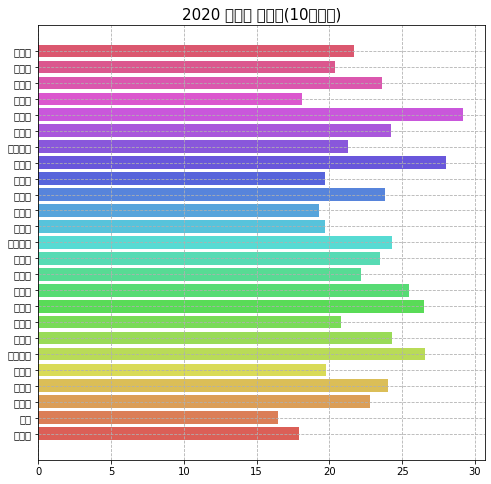

In [227]:
plt.figure(figsize=(8, 8))
colors = sns.color_palette('hls',len(seoul_sui_con)) ## 색상 지정
plt.barh(seoul_sui_con['시군구별'].values, seoul_sui_con['2020'].values, color=colors)
plt.grid(linestyle='dashed')
plt.title('2020 서울시 자살율(10만명당)', fontdict={'fontsize' : 15 })
plt.show()

### ** 수원시/창원시/진주시 자살율 (시각화)

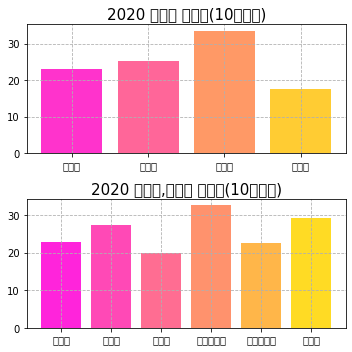

In [228]:
plt.figure(figsize=(5,5))
plt.subplot(2,1,1)
colors = sns.color_palette('spring',len(suwon_sui_con)) ## 색상 지정
plt.bar(suwon_sui_con['시군구별'].values, suwon_sui_con['2020'].values, color=colors)
plt.grid(linestyle='dashed')
plt.title('2020 수원시 자살율(10만명당)', fontdict={'fontsize' : 15 })

plt.subplot(2,1,2)
colors = sns.color_palette('spring',len(changwon_sui_con)) ## 색상 지정
plt.bar(changwon_sui_con['시군구별'].values, changwon_sui_con['2020'].values, color=colors)
plt.grid(linestyle='dashed')
plt.title('2020 창원시,진주시 자살율(10만명당)', fontdict={'fontsize' : 15 })
plt.tight_layout()
plt.show()

In [229]:
# 행정구별 자살율의 평균을 시 전체 평균으로 사용합니다.
suwon_sui_con = sui_con[sui_con['시군구별'].isin(suwon_sgg)]
changwon_sui_con = sui_con[sui_con['시군구별'].isin(changwon_sgg)]
print(f'수원 전체 평균 :', suwon_sui_con['2020'].mean()) # 수원 전체 평균 : 4개구의  평균
print(f'창원 전체 평균 :', changwon_sui_con['2020'].mean()) # 창원 전체 평균 : 5개구의  평균
add_sui_con = pd.DataFrame([['수원시',  suwon_sui_con['2020'].mean() ],
             ['창원시',  changwon_sui_con['2020'].mean()]], columns =['시군구별', '2020'])

수원 전체 평균 : 24.900000000000002
창원 전체 평균 : 25.7


In [230]:
# 시 전체 평균(수원,창원)과 기존 시,군,구 데이터를 Concat
sui_con_total = pd.concat([add_sui_con, sui_con])[['시군구별','2020']]
sui_con_total = sui_con_total.rename(columns={'2020' : '인구10만명당자살율'})

## <2> 화재발생통계

In [231]:
fire_con.head()

yr sido   sgg_nm  acc_num  dead_num  injr_num  tot_vic_num  prop_dmg  \
0  2018  경기도  수원시 권선구      108         0        18           18   1034047   
1  2018  경기도  수원시 영통구       89         1         2            3    302241   
2  2018  경기도  수원시 장안구       92         0         4            4    203169   
3  2018  경기도  수원시 팔달구       81         0        17           17    941048   
4  2019  경기도  수원시 권선구      124         0        11           11    331803   

   chattel_dmg  assts_dmg  dmg_per_acc  
0       756064    1790111        16575  
1       466660     768901         8639  
2       200131     403300         4384  
3      1031151    1972199        24348  
4       472602     804405         6487

In [232]:
# fire_con['yr'].unique() 2020년도 데이터 확인

In [233]:
fire_con = fire_con[fire_con['yr']==2020] # 2020년 기준 통계만 인덱싱
fire_con.head(3)

yr sido   sgg_nm  acc_num  dead_num  injr_num  tot_vic_num  prop_dmg  \
8   2020  경기도  수원시 권선구      166         2         4            6    866424   
9   2020  경기도  수원시 영통구      122         0         4            4    928800   
10  2020  경기도  수원시 장안구      145         1         7            8    305404   

    chattel_dmg  assts_dmg  dmg_per_acc  
8        649293    1515717         9131  
9        738234    1667034        13664  
10       332829     638233         4402

In [234]:
# 피해액 total
fire_con['total_dmg'] = fire_con['prop_dmg'] + fire_con['assts_dmg'] + fire_con['chattel_dmg']

In [235]:
fire_con = fire_con[['sido','sgg_nm','acc_num','tot_vic_num','total_dmg']]
fire_con['sgg_nm'] = fire_con['sgg_nm'].apply(lambda x : x.split(' ')[1] if ' ' in x else x )
fire_con.head()

sido sgg_nm  acc_num  tot_vic_num  total_dmg
8    경기도    권선구      166            6    3031434
9    경기도    영통구      122            4    3334068
10   경기도    장안구      145            8    1276466
11   경기도    팔달구      114           12    1712330
22  경상남도  마산합포구      111            9    4877388

## **행정구역별 화제발생통계 (시각화)

In [236]:
import plotly.express as px

# df = px.data.tips()
fig = px.scatter(fire_con, x="total_dmg", y="acc_num", size='tot_vic_num')
fig.show()

In [237]:
# fire_con['sgg_nm'].unique() 시군구 데이터 확인

In [238]:
suwon_fire_con = fire_con[fire_con['sgg_nm'].isin(suwon_sgg)]
changwon_fire_con = fire_con[fire_con['sgg_nm'].isin(changwon_sgg)]
# print(f'수원 전체 평균 :', ) # tot_vic_num total_dmg
# print(f'창원 전체 평균 :', changwon_fire_con['2020'].sum())

# 수원시, 창원시 시군구별 총계를 시 전체 데이터로 사용
add_fire_con = pd.DataFrame([['수원시',  suwon_fire_con['acc_num'].sum(),  suwon_fire_con['tot_vic_num'].sum() , suwon_fire_con['total_dmg'].sum()],
             ['창원시',  changwon_fire_con['acc_num'].sum(), changwon_fire_con['tot_vic_num'].sum(), changwon_fire_con['total_dmg'].sum()]], columns =['sgg_nm', 'acc_num', 'tot_vic_num', 'total_dmg'])

In [239]:
total_fire_con = pd.concat([add_fire_con, fire_con])
total_fire_con.loc[0,'sido' ] = '경기도'
total_fire_con.loc[1,'sido' ] = '경상남도'

In [240]:
fire_sui_df = pd.merge(total_fire_con, sui_con_total.rename(columns={'시군구별' : 'sgg_nm'}))
# del fire_sui_df['성별']
fire_sui_df.head()

sgg_nm  acc_num  tot_vic_num  total_dmg  sido  인구10만명당자살율
0    수원시      547           30    9354298   경기도    24.90000
1    창원시      835           34   13092638  경상남도    25.70000
2    권선구      166            6    3031434   경기도    25.30000
3    영통구      122            4    3334068   경기도    17.70000
4    장안구      145            8    1276466   경기도    23.00000

In [241]:
# fire_sui_df['sgg_nm'].nunique() 37개 확인
# fire_sui_df['sgg_nm'].unique()

In [242]:
fire_sui_df.to_csv('./data/4개시군구_자살율_화재발생통계.csv')

# 7. 공시지가, 지방세부담액
---
## 📢 4개 시군구의 소득 특성을 추출
- 공시지가 데이터를 통해 지역별 소득 특성을 추출 
- 1인당 지방세 부담액(<strong>납부액 = 지방소득세 + 가산세 +- 가감조정금액</strong> / **지방소득세 = 과세표준 x 0.1  )을 통해 소득 특성 추출

#### 지방세 데이터 출처
1. 행정안전부 주민1인당지방세부담액 출처 지방재정365(<a href="https://lofin.mois.go.kr/portal/service/openInfPage.do?infId=MQOWRNHF97LZGL278RU1241933">링크</a>)
2. 수원시 1인당 지방세부담액 출처 공공데이터포털(<a href="https://www.data.go.kr/data/15080169/fileData.do">링크</a>)
3. 창원시 1인당 지방세부담액 출처 공공데이터포털(<a href="https://www.data.go.kr/data/15078670/fileData.do">링크</a>)

In [243]:
changwon_tax_con = pd.read_csv('./data/경상남도 창원시_1인당 지방세 부담액.csv', encoding='euc-kr')
suwon_tax_con = pd.read_csv('./data/경기도 수원시_1인당지방세부담액.csv', encoding='euc-kr')
tax_con = pd.read_csv('./data/주민1인당지방세부담액.csv')
# tax_con.head(3)

## <1> 1인당 지방세 부담액 

In [244]:
## 수원, 창원은 tax_con 데이터에 구 단위 데이터가 존재하지 않아서 따로 데이터를 불러왔다.
changwon_tax_con = changwon_tax_con.rename(columns={' 세대당부담금액' : '세대당부담금액'})
suwon_tax_con = suwon_tax_con[suwon_tax_con['과세년도']==2019]
changwon_tax_con = changwon_tax_con[changwon_tax_con['과세년도']==2019]

In [245]:
# 주민1인당 부담금액으로 형식을 맞추기 위해 apply 적용
tax_gu_con = pd.concat([suwon_tax_con, changwon_tax_con])[['시군구명','주민1인당 부담금액','세대당부담금액']]
# tax_con.dropna(subset=['시군구명'], inplace=True)
tax_gu_con['주민1인당 부담금액'] = tax_gu_con['주민1인당 부담금액'].apply(lambda x: int(str(x).replace(',' ,'')) if ',' in str(x) else x)
tax_gu_con['세대당부담금액'] = tax_gu_con['세대당부담금액'].apply(lambda x: int(str(x).replace(',' ,'')) if ',' in str(x) else x)
tax_gu_con.head()

시군구명  주민1인당 부담금액  세대당부담금액
8   수원시권선구      862490  2099320
9   수원시영통구     2545850  6397010
10  수원시장안구      627870  1517510
11  수원시팔달구     2054130  4286240
10     의창구     1811054  4384188

In [246]:
seoul_tax = tax_con[1:][tax_con['자치단체명'].str.contains('서울')]
si_tax = tax_con[tax_con['자치단체명'].isin(['경기수원시', '경남창원시', '경남진주시'])]
tax_df = pd.concat([seoul_tax, si_tax])[['자치단체명', '주민1인당 지방세부담액(천원)', '지방세액(천원)','인구수(명)']]
tax_df.head(3)

자치단체명  주민1인당 지방세부담액(천원)   지방세액(천원)  인구수(명)
1  서울종로구               832  125918651  151290
2   서울중구              1330  167760485  126171
3  서울용산구               599  137069000  228670

In [249]:
tax_df.to_csv('./data/4개시군구_지방세현황.csv')

In [250]:
# tax_df['자치단체명'].unique() # 행정구역명 확인
# tax_df['자치단체명'].nunique() 

In [251]:
tax_df['시군구명'] = tax_df['자치단체명'].apply(lambda x: x.replace('서울', '').replace('경기', '').replace('경남', ''))
tax_df['주민1인당 부담금액'] = tax_df['주민1인당 지방세부담액(천원)'].apply(lambda x: x * 1000) # 1인당 부담금액 단위 맞추기
tax_df.head(3) 

자치단체명  주민1인당 지방세부담액(천원)   지방세액(천원)  인구수(명) 시군구명  주민1인당 부담금액
1  서울종로구               832  125918651  151290  종로구      832000
2   서울중구              1330  167760485  126171   중구     1330000
3  서울용산구               599  137069000  228670  용산구      599000

In [252]:
tax_df.to_csv('./data/4개시군구_지방세현황.csv')
total_tax_con = pd.concat([tax_df, tax_gu_con])[['시군구명','주민1인당 부담금액']]
total_tax_con.sort_values(ascending=False, by = '주민1인당 부담금액').head(3) # 지방세 부담액 최종!

시군구명  주민1인당 부담금액
9   수원시영통구     2545850
11  수원시팔달구     2054130
10     의창구     1811054

## <2> 공시지가데이터

#### 공시지가 데이터, 국가공간정보포털 국토교통부 제공 (<a href="http://data.nsdi.go.kr/dataset/20200305ds00002">링크</a>)

In [253]:
# 시,군, 구 별 지가 데이터를 로드
seoul_land = pd.read_csv('./data/APMM_NV_JIGA_MNG_11_서울.txt', encoding='euc-kr', sep='|')
kk_land = pd.read_csv('./data/APMM_NV_JIGA_MNG_41_경기.txt', encoding='euc-kr', sep='|')
kn_land = pd.read_csv('./data/APMM_NV_JIGA_MNG_48_경남.txt', encoding='euc-kr', sep='|')

kk_land['PNU'] = kk_land['PNU'].astype(str)
suwon_land = kk_land[kk_land['COL_ADM_SECT_CD'] == 41110] # 4110 : 수원시 코드
changwon_jinju_land = kn_land[kn_land['COL_ADM_SECT_CD'].isin(['48120', '48170'])] 
# kk_land[kk_land['COL_ADM_SECT_CD'].isin(np.arange(41110, 41118))]

#### 시군구 코드 매칭을 위해서 행정구역 경계데이터 로드

In [254]:
# 서울
seoul_area = gpd.GeoDataFrame.from_file('data/LARD_ADM_SECT_SGG_11.shp', encoding='cp949')
# 경기 --> 수원시 추출
kk_area = gpd.GeoDataFrame.from_file('data/LARD_ADM_SECT_SGG_41.shp', encoding='cp949')
suwon_area = kk_area[kk_area['SGG_NM'].str.contains('수원')]
# 경남 --> 창원통합시, 진주시 추출
kn_area = gpd.GeoDataFrame.from_file('data/LARD_ADM_SECT_SGG_48.shp', encoding='cp949')
changwon_jinju_area = kn_area[kn_area['ADM_SECT_C'].isin(['48120', '48170', '48121', '48123', '48125', '48129', '48127'])]

In [255]:
total_area = pd.concat([seoul_area, suwon_area, changwon_jinju_area]).to_crs({'init':'epsg:4326'})
total_area['GID'] = total_area['GID'].astype(str)
total_area.head()

ADM_SECT_C SGG_NM  SGG_OID COL_ADM_SE  GID  \
0      11740    강동구      337      11740  127   
1      11710    송파구     1969      11710  128   
2      11680    강남구       33      11680  129   
3      11650    서초구       33      11650  130   
4      11620    관악구       33      11620  131   

                                            geometry  
0  POLYGON ((127.15717 37.53844, 127.15694 37.538...  
1  POLYGON ((127.14520 37.50358, 127.14520 37.503...  
2  POLYGON ((127.03249 37.53584, 127.03814 37.535...  
3  POLYGON ((127.02643 37.45892, 127.02644 37.458...  
4  POLYGON ((126.92669 37.49418, 126.92672 37.494...

In [256]:
# 서울, 수원, 창원/진주시만 추출하여 concat
land_total=pd.concat([seoul_land, suwon_land, changwon_jinju_land])
land_total.head(3)

PNU  BASE_YEAR  STDMT    PNILP  PJJI_YN  PANN_YMD  \
0  1111010100100340000       2020      7  4747000        0  20201030   
1  1111010100100370006       2020      7  1582000        0  20201030   
2  1111010100100370007       2020      7  4747000        0  20201030   

   ETC_CNTN  COL_ADM_SECT_CD  
0       nan            11110  
1       nan            11110  
2       nan            11110

In [257]:
# PNU에서 시군구 코드, 읍면동 코드를 슬라이싱!
land_total['PNU'] = land_total['PNU'].astype(str)
land_total['sgg_cd'] = land_total['PNU'].apply(lambda x: x[:5])
land_total['dong_cd'] = land_total['PNU'].apply(lambda x: x[5:8])

In [258]:
# 시군구 코드로 매칭
land_total['COL_ADM_SECT_CD'] = land_total['COL_ADM_SECT_CD'].astype(str)
df = pd.merge(land_total, total_area.rename(columns={'ADM_SECT_C' : 'sgg_cd'}))
suwon_df = df[df['SGG_NM'].str.contains('수원시')]
changwon_df = df[df['SGG_NM'].str.contains('창원시')]
# 수원, 창원 전체 데이터의 평균지가는 각 시군구의 평균으로 인서트
print(f'수원 전체 평균 :', suwon_df['PNILP'].mean())
print(f'창원 전체 평균 :', changwon_df['PNILP'].mean())
add_df = pd.DataFrame([['수원시',  788858.2768635043 ],
             ['창원시', 270335.3503649635]], columns =['SGG_NM','PNILP'])

수원 전체 평균 : 788858.2768635043
창원 전체 평균 : 270335.3503649635


In [259]:
# 시군구별 지가데이터 평균 최종
pd.options.display.float_format = '{:.5f}'.format
land_mean_df = pd.concat([df[['SGG_NM','PNILP']].groupby('SGG_NM').mean().reset_index(), add_df])
land_mean_df.head(3)

SGG_NM         PNILP
0    강남구 9144318.51852
1    강동구 3218244.07895
2    강북구 1158908.12500

In [260]:
land_mean_df['SGG_NM'] = land_mean_df['SGG_NM'].apply(lambda x : x.replace('창원시', '') if len(x) > 3 and '창원시' in x else x)
land_mean_df['SGG_NM'] = land_mean_df['SGG_NM'].apply(lambda x : x.replace('서울시', '') )

#### 1인당 지방세 납부금액데이터와 지가데이터를 종합합니다.

In [261]:
tax_land_total = pd.merge(total_tax_con.rename(columns={'시군구명':'SGG_NM'}), land_mean_df)
tax_land_total.head()

SGG_NM  주민1인당 부담금액         PNILP
0    종로구      832000 3740234.25197
1     중구     1330000 7147187.50000
2    용산구      599000 5275915.38462
3    성동구      376000 5557570.48193
4    광진구      273000 3342153.84615

In [262]:
# tax_land_total['SGG_NM'].nunique() 시,군,구 확인

In [263]:
tax_land_total.to_csv('./data/지방세부담액_공시지가.csv') # 최종

# 8. 최종 특성 도출
---
### 📢 1 ~ 7에서 생성한 데이터를 바탕으로 지역별 최종 특성을 도출

In [264]:
# 시설물 종합 (cctv, 비상벨, 보안등 등등 ..)
facility_total = pd.read_csv('./data/4개시군구_설치시설물종합.csv')
del facility_total['Unnamed: 0']

# 용도지역_토지이용계획도
use_land_total = pd.read_csv('./data/4개시군구_용도지역_토지이용계획도.csv')
del use_land_total['Unnamed: 0']

# 주택노후도
house_total = pd.read_csv('./data/4개시군구_주택노후도.csv')
del house_total['Unnamed: 0']

# 인구현황
popu_total = pd.read_csv('./data/4개시군구_인구및주택현황.csv')
del popu_total['Unnamed: 0']

# 112 신고 현황
report_total = pd.read_csv('./data/112신고현황.csv')
del report_total['Unnamed: 0']

# 관할서영역및 개수
police_total=pd.read_csv('./data/관할서영역및개수.csv')
del police_total['Unnamed: 0']

# 지방세부담액, 공시지가
tax_land_total = pd.read_csv('./data/지방세부담액_공시지가.csv')
del tax_land_total['Unnamed: 0']

# 자살율, 화재
sui_fire_total = pd.read_csv('./data/4개시군구_자살율_화재발생통계.csv')
del sui_fire_total['Unnamed: 0']

#### 전체 특성 Merge를 위해 포맷을 잘 맞춰줍니다

In [265]:
facility_total['sgg_nm'] = facility_total['sgg_nm'].apply(lambda x: x.replace('창원시','').replace('수원시','').replace('서울시', '') if len(x)>3 else x)
use_land_total['sgg_nm'] = use_land_total['sgg_nm'].apply(lambda x: x.replace('창원시','').replace('수원시','').replace('서울시', '') if len(x)>3 else x)

police_total = police_total.rename(columns={'SGG_NM' : 'sgg_nm'})
police_total['sgg_nm'] = police_total['sgg_nm'].apply(lambda x: x.replace('창원시','').replace('수원시','').replace('서울시', '') if len(x)>3 else x)

tax_land_total = tax_land_total.rename(columns={'SGG_NM' : 'sgg_nm'})
tax_land_total['sgg_nm'] = tax_land_total['sgg_nm'].apply(lambda x: x.replace('창원시','').replace('수원시','').replace('서울시', '') if len(x)>3 else x)

In [266]:
pop_report = pd.merge(popu_total, report_total)
pop_report.head(3)
# pop_report['sgg_nm'].nunique()

sgg_nm  총인구 (명)  남자 (명)  여자 (명)  내국인-계 (명)  내국인-남자 (명)  내국인-여자 (명)  \
0    종로구   151291   73062   78229     139718       67919       71799   
1     중구   128744   62147   66597     117252       56725       60527   
2    용산구   225882  109162  116720     208602       99866      108736   

   외국인-계 (명)  외국인-남자 (명)  외국인-여자 (명)  ...  single_합계  case_type  교통_case_cnt  \
0      11573        5143        6430  ...      25983      66480         7087   
1      11492        5422        6070  ...     127233      58679         6771   
2      17280        9296        7984  ...      36881      61657         8834   

   기타_case_cnt  서비스_case_cnt  시비/폭력_case_cnt  절도/경범_case_cnt   교통신고비율  \
0        11569         17703           14329           15792 10.66035   
1         9991         16160           11989           13768 11.53905   
2        14144         13215           11544           13920 14.32765   

   기타및서비스비율  절도폭력및경범비율  
0  44.03129   45.30836  
1  44.56620   43.89475  
2  44.37290   41.29945  

[3 rows x 38 columns]

#### 인구특성에 비율 기반 특성을 추가로 넣어주었습니다.

In [267]:
# 주택(호) 비율
pop_report['house_ratio'] = round(pop_report['주택-계 (호)'] / pop_report['가구-계 (가구)'] * 100, 2)
# 1인가구 비율
pop_report['single_ratio'] = round(pop_report['single_합계'] / pop_report['총인구 (명)'] * 100, 2)
# 기초수급자 비율
pop_report['single_ratio'] = round(pop_report['poor_num'] / pop_report['총인구 (명)'] * 100, 2)

#### 신고특성에 비율 기반(인구대비) 특성을 추가로 넣어주었습니다.

In [268]:
# 인구대비 신고 수 전체 통계
pop_report['report_ratio'] = round(pop_report['case_type'] / pop_report['총인구 (명)'], 2) * 100
# 인구 대비 교통 관련 신고 수
pop_report['report_traffic_ratio'] = round(pop_report['교통_case_cnt'] / pop_report['총인구 (명)'], 2) * 100
# 인구 대비 시비 폭력 관련 신고 수
pop_report['report_vio_ratio'] = round(pop_report['시비/폭력_case_cnt'] / pop_report['총인구 (명)'], 2) * 100
# 인구 대비 절도 경범 관련 신고 수
pop_report['report_crime_ratio'] = round(pop_report['절도/경범_case_cnt'] / pop_report['총인구 (명)'], 2) * 100

In [269]:
facility_land = pd.merge(facility_total, use_land_total.drop(['total_area'], axis=1), how='outer', on='sgg_nm')
facility_land.isnull().sum()

# Na 값 출력 결과, 동작구 / 영등포구 / 동대문구 / 용산구 / 광진구/ 중구 / 종로구 / 성산구가 비어 있음(일부 용지 사용율이 0이라서)
facility_land.fillna(0, inplace=True) # fillNa 0 로 처리!

In [270]:
report_police = pd.merge(report_total, police_total, how='outer')
# 파출소 1개별 접수건수 특성을 추가해줍니다. (총 접수건수 / 파출소(치안안전센터)개수)
report_police['case_for_sec'] = report_police['case_type']  / report_police['security_cnt']

In [271]:
house_old_sui_fire = pd.merge(house_total, sui_fire_total)
house_sui_fire_land_tax_ = pd.merge(house_old_sui_fire, tax_land_total)
house_sui_fire_land_tax_.head()

sgg_nm  OLD_YEAR  area_old_level_1  area_old_level_2  area_old_level_3  \
0    강남구  27.00000           0.10272           1.58321           1.84929   
1    강동구  26.10000           0.44948           0.82360           0.73865   
2    강북구  31.80000           0.32225           0.57927           0.92802   
3    강서구  27.00000           0.27076           1.49532           1.59307   
4    관악구  26.80000           0.40570           1.04620           1.36264   

   area_old_level_4  acc_num  tot_vic_num  total_dmg   sido  인구10만명당자살율  \
0           2.25640      387           19    2903112  서울특별시    23.60000   
1           1.36019      221           22     727678  서울특별시    21.70000   
2           1.46886      186            6     416760  서울특별시    26.50000   
3           1.55037      212            8     401932  서울특별시    23.80000   
4           1.59885      219           17    1292298  서울특별시    29.20000   

   주민1인당 부담금액         PNILP  
0      691000 9144318.51852  
1      284000 3218244.07895  
2      253000 1158908.12500  
3      247000 1477496.80851  
4      194000 2864556.45570

In [272]:
temp_1 = pd.merge(pop_report, facility_land)
temp_2 = pd.merge(report_police, house_sui_fire_land_tax_)

In [273]:
final_df = pd.merge(temp_1,temp_2)
final_df.head(3)

sgg_nm  총인구 (명)  남자 (명)  여자 (명)  내국인-계 (명)  내국인-남자 (명)  내국인-여자 (명)  \
0    종로구   151291   73062   78229     139718       67919       71799   
1     중구   128744   62147   66597     117252       56725       60527   
2    용산구   225882  109162  116720     208602       99866      108736   

   외국인-계 (명)  외국인-남자 (명)  외국인-여자 (명)  ...  area_old_level_1  area_old_level_2  \
0      11573        5143        6430  ...           0.03520           0.43504   
1      11492        5422        6070  ...           0.05981           0.37726   
2      17280        9296        7984  ...           0.11881           0.67230   

   area_old_level_3  area_old_level_4  acc_num  tot_vic_num  total_dmg  \
0           0.70887           1.45763      217            7    1279502   
1           0.44550           1.38739      185           10    2568844   
2           0.70362           1.62675      192            5     539670   

   인구10만명당자살율  주민1인당 부담금액         PNILP  
0    17.90000      832000 3740234.25197  
1    16.50000     1330000 7147187.50000  
2    22.80000      599000 5275915.38462  

[3 rows x 88 columns]

In [274]:
# 면적당 신고수
final_df['report_for_area']= final_df['case_type'] / final_df['total_area']

In [275]:
print(f'최종 특성 수 : {len(final_df.columns)}')
final_df.columns # 최종 특성 개수 확인

최종 특성 수 : 89


Index(['sgg_nm', '총인구 (명)', '남자 (명)', '여자 (명)', '내국인-계 (명)', '내국인-남자 (명)',
       '내국인-여자 (명)', '외국인-계 (명)', '외국인-남자 (명)', '외국인-여자 (명)', '가구-계 (가구)',
       '일반가구 (가구)', '집단가구 (가구)', '외국인가구 (가구)', '주택-계 (호)', '단독주택 (호)',
       '아파트 (호)', '연립주택 (호)', '다세대주택 (호)', '비거주용 건물내 주택 (호)', '주택이외의 거처 (호)',
       '세대당 인구수', '성비', '외국인 비율', 'sido', 'poor_num', 'single_20대',
       'single_65세 이상', 'single_합계', 'case_type', '교통_case_cnt', '기타_case_cnt',
       '서비스_case_cnt', '시비/폭력_case_cnt', '절도/경범_case_cnt', '교통신고비율',
       '기타및서비스비율', '절도폭력및경범비율', 'house_ratio', 'single_ratio', 'report_ratio',
       'report_traffic_ratio', 'report_vio_ratio', 'report_crime_ratio',
       'total_area', 'securitylight_cnt', 'cctv_cnt', 'bell_cnt', 'park_cnt',
       'pub_cnt', 'play_cnt', 'conv_cnt', 'cctv밀도', '보안등밀도', '비상벨밀도', '유흥업소밀도',
       '편의점밀도', '공원및놀이시설밀도', '녹지지역_use_ratio', '상업지역_use_ratio',
       '주거지역_use_ratio', '공업지역_use_ratio', '기타_use_ratio', '농경지역_use_ratio',
       'plan_total_area', '공공용지_

In [276]:
final_df.to_csv("./data/4개시군구_종합.csv")